<a href="https://colab.research.google.com/github/OlegPozovnoy/RLHW3/blob/master/10_gan2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import pickle

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple
from itertools import count

import cProfile
from datetime import datetime

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
#rc('font',**{'family':'sans-serif'})
#rc('text', usetex=True)
#rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
#rc('text.latex',preamble=r'\usepackage[russian]{babel}')
#rc('figure', **{'dpi': 300})

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.autograd import Variable
from torchvision.utils import save_image

import torchvision.datasets as datasets
from torchvision.utils import make_grid

## Pix2Pix

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def plot_losses(d_losses, g_losses):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111)

    n_epochs = len(d_losses) - 1
    x_train = np.linspace(0, n_epochs, len(d_losses))
    x_test = np.arange(n_epochs + 1)

    ax.plot(x_train, d_losses, label='Ошибка дискриминатора')
    ax.plot(x_test, g_losses, label='Ошибка генератора')
    ax.legend()
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Ошибка')
    plt.show()

In [5]:

class ConvBlock(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size=4, stride=2, padding=1, activation=True, batch_norm=True):
        super(ConvBlock, self).__init__()
        self.conv = torch.nn.Conv2d(input_size, output_size, kernel_size, stride, padding)
        self.activation = activation
        self.lrelu = torch.nn.LeakyReLU(0.2, True)
        self.batch_norm = batch_norm
        self.bn = torch.nn.BatchNorm2d(output_size)

    def forward(self, x):
        if self.activation:
            out = self.conv(self.lrelu(x))
        else:
            out = self.conv(x)

        if self.batch_norm:
            return self.bn(out)
        else:
            return out


class DeconvBlock(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size=4, stride=2, padding=1, batch_norm=True):
        super(DeconvBlock, self).__init__()
        self.deconv = torch.nn.ConvTranspose2d(input_size, output_size,
                                               kernel_size, stride, padding)
        self.bn = torch.nn.BatchNorm2d(output_size)
        self.drop = torch.nn.Dropout(0.25)
        self.relu = torch.nn.ReLU(True)
        self.batch_norm = batch_norm

    def forward(self, x):
        if self.batch_norm:
            out = self.bn(self.deconv(self.relu(x)))
        else:
            out = self.deconv(self.relu(x))

        return out


class Generator(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()


        self.conv1 = ConvBlock(input_dim, 64, activation=False, batch_norm=False)
        self.conv2 = ConvBlock(64, 128)
        self.conv3 = ConvBlock(128, 256)
        self.conv4 = ConvBlock(256, 512)
        self.conv5 = ConvBlock(512, 512, batch_norm=False)

        self.deconv1 = DeconvBlock(512, 512)
        self.deconv2 = DeconvBlock(1024, 256)
        self.deconv3 = DeconvBlock(512, 128)
        self.deconv4 = DeconvBlock(256, 64)
        self.deconv5 = DeconvBlock(128, output_dim, batch_norm=False)

    def forward(self, x):
        enc1 = self.conv1(x)
        enc2 = self.conv2(enc1)
        enc3 = self.conv3(enc2)
        enc4 = self.conv4(enc3)
        enc5 = self.conv5(enc4)

        dec1 = self.deconv1(enc5)
        dec1 = torch.cat([dec1, enc4], 1)
        dec2 = self.deconv2(dec1)
        dec2 = torch.cat([dec2, enc3], 1)
        dec3 = self.deconv3(dec2)
        dec3 = torch.cat([dec3, enc2], 1)
        dec4 = self.deconv4(dec3)
        dec4 = torch.cat([dec4, enc1], 1)
        dec5 = self.deconv5(dec4)
        out = torch.nn.Tanh()(dec5)
        return out


class Discriminator(torch.nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()

        self.conv1 = ConvBlock(input_dim, 64, activation=False, batch_norm=False)
        self.conv2 = ConvBlock(64, 128)
        self.conv3 = ConvBlock(128, 256)
        self.conv4 = ConvBlock(256, 512, stride=1)
        self.conv5 = ConvBlock(512, 1, stride=1, batch_norm=False)

    def forward(self, x, label):
        x = torch.cat([x, label], 1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        out = torch.nn.Sigmoid()(x)
        return out

    def normal_weight_init(self, mean=0.0, std=0.02):
        for m in self.children():
            if isinstance(m, ConvBlock):
                torch.nn.init.normal(m.conv.weight, mean, std)




In [7]:
import torch.utils.data as data
import os
from PIL import Image

class loadData(data.Dataset):
    def __init__(self, image_dir, subfolder, transform):
        super(loadData, self).__init__()
        self.input_path = os.path.join(image_dir, subfolder)
        self.image_filenames = [x for x in sorted(os.listdir(self.input_path))]
        self.transform = transform

    def __getitem__(self, index):
        fileim = os.path.join(self.input_path, self.image_filenames[index])
        img = Image.open(fileim)
        
        image = img.crop((0, 0, img.width // 2, img.height))
        templ = img.crop((img.width // 2, 0, img.width, img.height))
        
        image = self.transform(image)
        templ = self.transform(templ)

        return templ, image

    def __len__(self):
        return len(self.image_filenames)

	...epoch 0/100	batch 0/7	D loss: 1.411667	G loss: 66.224449
	...epoch 0/100	batch 1/7	D loss: 1.664620	G loss: 59.657192
	...epoch 0/100	batch 2/7	D loss: 1.581925	G loss: 53.926270
	...epoch 0/100	batch 3/7	D loss: 1.448056	G loss: 51.669060
	...epoch 0/100	batch 4/7	D loss: 1.354794	G loss: 49.979500
	...epoch 0/100	batch 5/7	D loss: 1.321823	G loss: 46.626133
	...epoch 0/100	batch 6/7	D loss: 1.267549	G loss: 44.043728


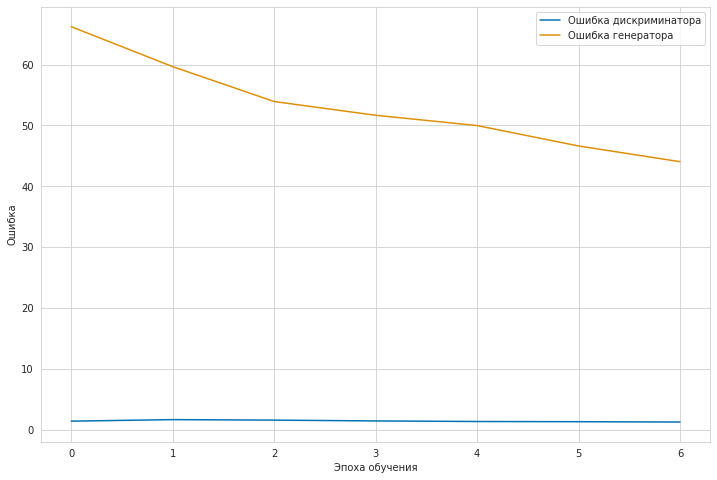

	...epoch 1/100	batch 0/7	D loss: 1.248794	G loss: 44.715473
	...epoch 1/100	batch 1/7	D loss: 1.217234	G loss: 44.653896
	...epoch 1/100	batch 2/7	D loss: 1.182448	G loss: 42.929653
	...epoch 1/100	batch 3/7	D loss: 1.140654	G loss: 42.104256
	...epoch 1/100	batch 4/7	D loss: 1.069834	G loss: 44.540527
	...epoch 1/100	batch 5/7	D loss: 1.051123	G loss: 42.129311
	...epoch 1/100	batch 6/7	D loss: 1.051902	G loss: 41.259186


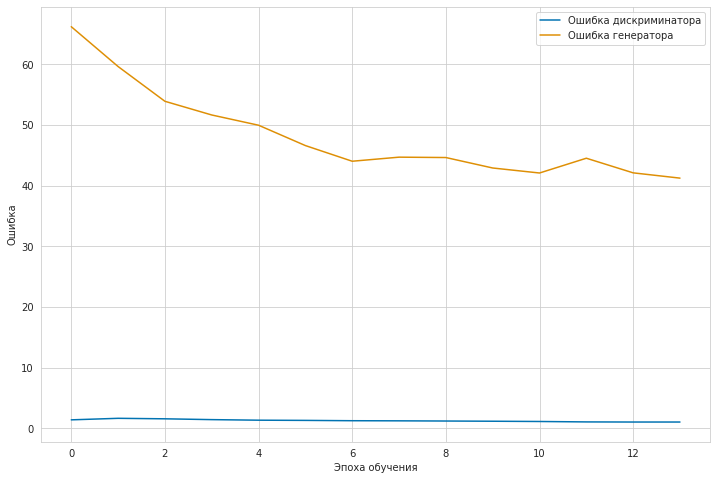

	...epoch 2/100	batch 0/7	D loss: 1.111771	G loss: 41.732285
	...epoch 2/100	batch 1/7	D loss: 0.971411	G loss: 41.674675
	...epoch 2/100	batch 2/7	D loss: 0.891620	G loss: 40.295700
	...epoch 2/100	batch 3/7	D loss: 0.880322	G loss: 39.914238
	...epoch 2/100	batch 4/7	D loss: 0.758985	G loss: 41.528656
	...epoch 2/100	batch 5/7	D loss: 0.706170	G loss: 40.250378
	...epoch 2/100	batch 6/7	D loss: 0.788543	G loss: 39.800869


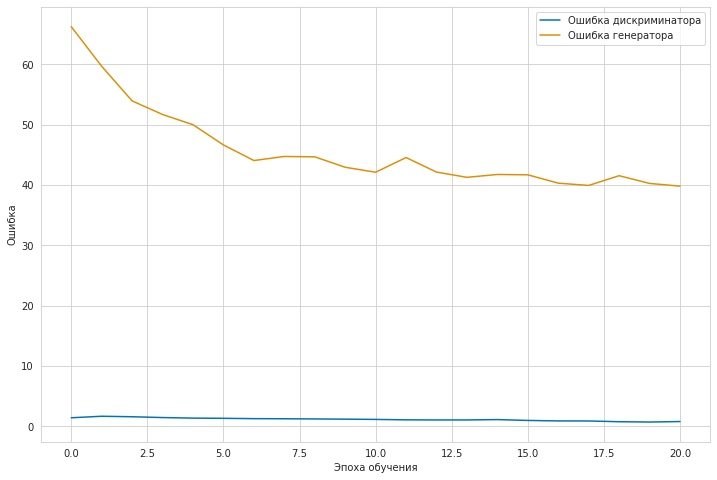

	...epoch 3/100	batch 0/7	D loss: 1.061484	G loss: 42.256927
	...epoch 3/100	batch 1/7	D loss: 0.830274	G loss: 40.229084
	...epoch 3/100	batch 2/7	D loss: 0.728431	G loss: 39.404324
	...epoch 3/100	batch 3/7	D loss: 0.632365	G loss: 39.958263
	...epoch 3/100	batch 4/7	D loss: 0.587660	G loss: 39.400761
	...epoch 3/100	batch 5/7	D loss: 0.569424	G loss: 38.237488
	...epoch 3/100	batch 6/7	D loss: 0.545200	G loss: 40.071949


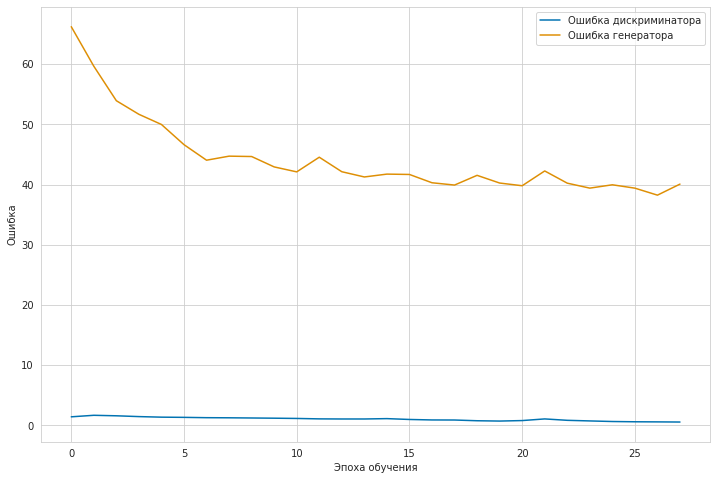

	...epoch 4/100	batch 0/7	D loss: 0.462618	G loss: 39.737450
	...epoch 4/100	batch 1/7	D loss: 0.447398	G loss: 39.585270
	...epoch 4/100	batch 2/7	D loss: 0.383177	G loss: 39.110222
	...epoch 4/100	batch 3/7	D loss: 0.411552	G loss: 39.077290
	...epoch 4/100	batch 4/7	D loss: 0.427086	G loss: 38.678932
	...epoch 4/100	batch 5/7	D loss: 0.413941	G loss: 39.230759
	...epoch 4/100	batch 6/7	D loss: 0.354460	G loss: 39.342388


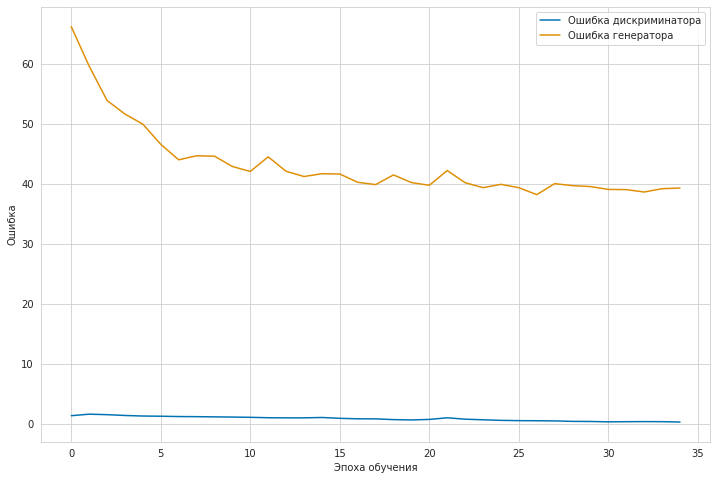

	...epoch 5/100	batch 0/7	D loss: 0.375653	G loss: 39.766148
	...epoch 5/100	batch 1/7	D loss: 0.317047	G loss: 38.651070
	...epoch 5/100	batch 2/7	D loss: 0.261531	G loss: 40.154133
	...epoch 5/100	batch 3/7	D loss: 0.243913	G loss: 39.608696
	...epoch 5/100	batch 4/7	D loss: 0.250353	G loss: 37.541466
	...epoch 5/100	batch 5/7	D loss: 0.232737	G loss: 37.982510
	...epoch 5/100	batch 6/7	D loss: 0.315816	G loss: 39.594559


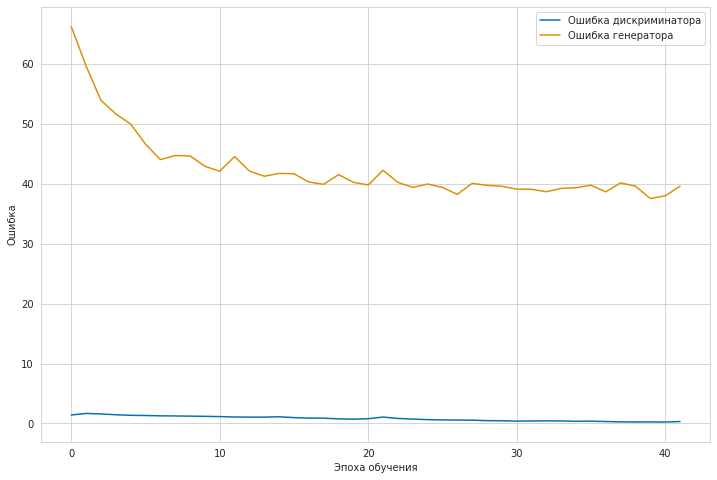

	...epoch 6/100	batch 0/7	D loss: 0.667319	G loss: 38.458572
	...epoch 6/100	batch 1/7	D loss: 1.764972	G loss: 39.828499
	...epoch 6/100	batch 2/7	D loss: 0.820161	G loss: 37.788536
	...epoch 6/100	batch 3/7	D loss: 0.986542	G loss: 38.020317
	...epoch 6/100	batch 4/7	D loss: 0.877805	G loss: 38.412552
	...epoch 6/100	batch 5/7	D loss: 0.759020	G loss: 38.279602
	...epoch 6/100	batch 6/7	D loss: 1.218813	G loss: 38.097736


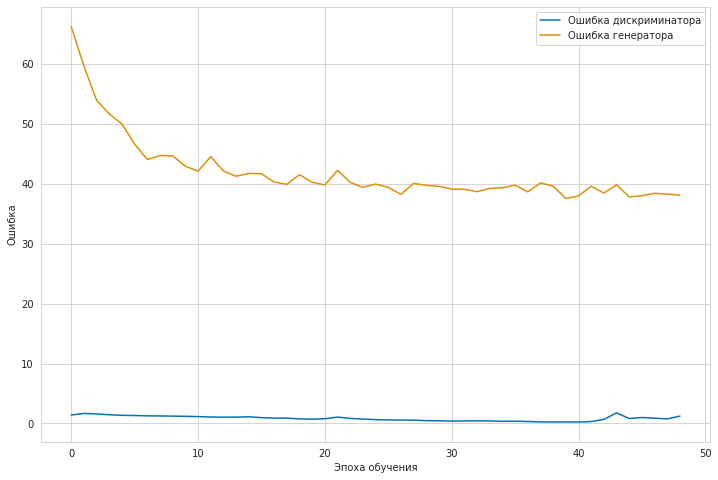

	...epoch 7/100	batch 0/7	D loss: 0.800920	G loss: 38.594162
	...epoch 7/100	batch 1/7	D loss: 0.762167	G loss: 38.048622
	...epoch 7/100	batch 2/7	D loss: 0.893237	G loss: 37.676414
	...epoch 7/100	batch 3/7	D loss: 0.795033	G loss: 37.948975
	...epoch 7/100	batch 4/7	D loss: 0.877501	G loss: 37.051071
	...epoch 7/100	batch 5/7	D loss: 0.637925	G loss: 38.530800
	...epoch 7/100	batch 6/7	D loss: 0.519536	G loss: 37.368217


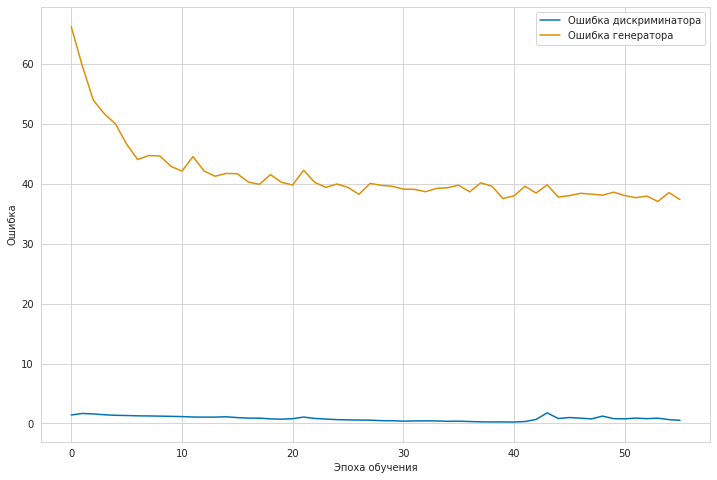

	...epoch 8/100	batch 0/7	D loss: 0.537673	G loss: 38.751160
	...epoch 8/100	batch 1/7	D loss: 0.509337	G loss: 39.189682
	...epoch 8/100	batch 2/7	D loss: 0.537350	G loss: 38.086025
	...epoch 8/100	batch 3/7	D loss: 0.797637	G loss: 37.389782
	...epoch 8/100	batch 4/7	D loss: 1.301758	G loss: 37.577717
	...epoch 8/100	batch 5/7	D loss: 0.722884	G loss: 36.285168
	...epoch 8/100	batch 6/7	D loss: 0.975341	G loss: 37.012321


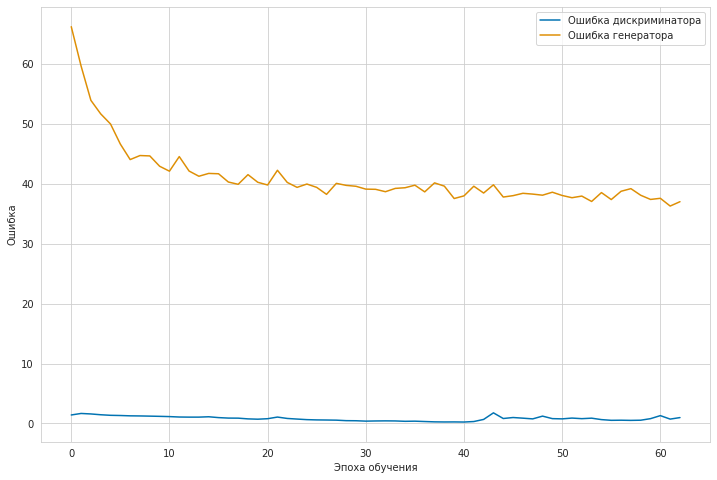

	...epoch 9/100	batch 0/7	D loss: 0.983198	G loss: 37.514503
	...epoch 9/100	batch 1/7	D loss: 0.678890	G loss: 35.989044
	...epoch 9/100	batch 2/7	D loss: 0.763054	G loss: 38.514431
	...epoch 9/100	batch 3/7	D loss: 0.725152	G loss: 36.473545
	...epoch 9/100	batch 4/7	D loss: 0.501526	G loss: 39.563759
	...epoch 9/100	batch 5/7	D loss: 0.568638	G loss: 36.667294
	...epoch 9/100	batch 6/7	D loss: 0.486619	G loss: 37.376022


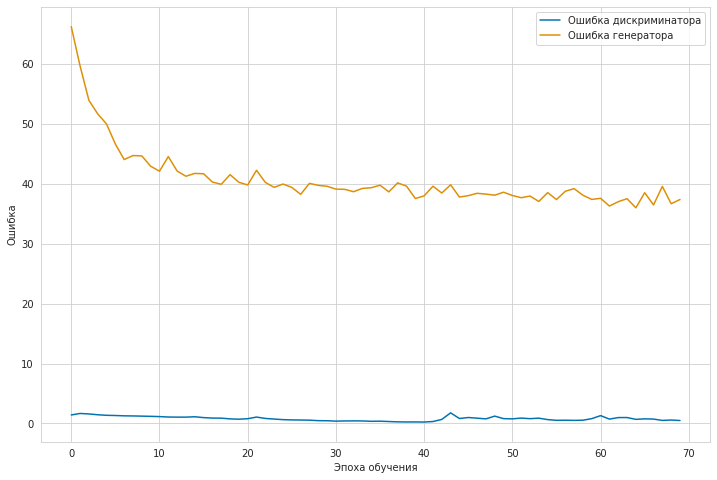

	...epoch 10/100	batch 0/7	D loss: 0.653374	G loss: 37.642273
	...epoch 10/100	batch 1/7	D loss: 0.531784	G loss: 37.130558
	...epoch 10/100	batch 2/7	D loss: 0.518108	G loss: 38.142643
	...epoch 10/100	batch 3/7	D loss: 0.550853	G loss: 38.790596
	...epoch 10/100	batch 4/7	D loss: 0.646145	G loss: 37.193638
	...epoch 10/100	batch 5/7	D loss: 0.812921	G loss: 37.589333
	...epoch 10/100	batch 6/7	D loss: 0.767835	G loss: 39.982185


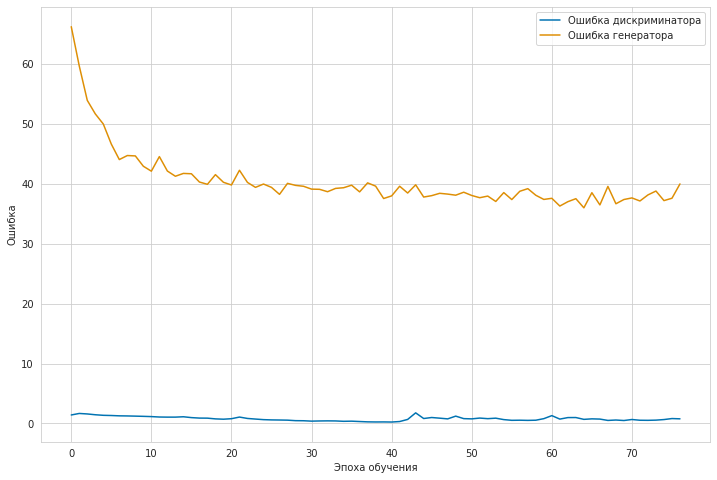

	...epoch 11/100	batch 0/7	D loss: 0.805572	G loss: 37.974030
	...epoch 11/100	batch 1/7	D loss: 0.644681	G loss: 37.498894
	...epoch 11/100	batch 2/7	D loss: 0.449637	G loss: 37.050449
	...epoch 11/100	batch 3/7	D loss: 0.549127	G loss: 36.822403
	...epoch 11/100	batch 4/7	D loss: 0.550014	G loss: 36.579292
	...epoch 11/100	batch 5/7	D loss: 0.414924	G loss: 38.558609
	...epoch 11/100	batch 6/7	D loss: 0.423459	G loss: 37.836708


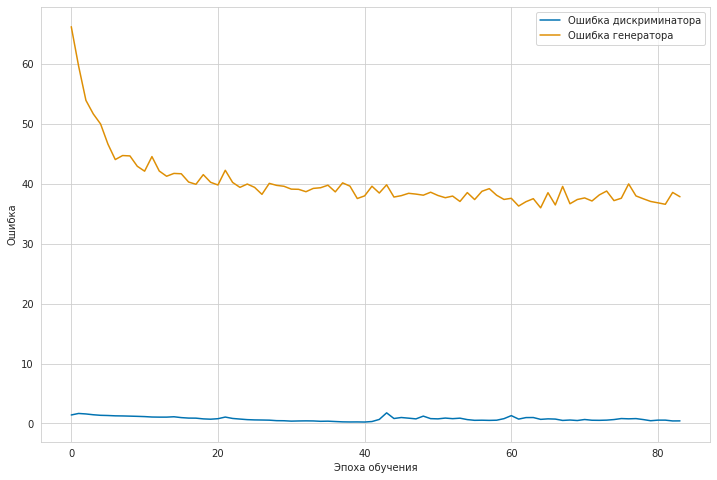

	...epoch 12/100	batch 0/7	D loss: 0.700655	G loss: 38.720383
	...epoch 12/100	batch 1/7	D loss: 0.911184	G loss: 37.278584
	...epoch 12/100	batch 2/7	D loss: 0.539988	G loss: 38.389210
	...epoch 12/100	batch 3/7	D loss: 0.561283	G loss: 39.647511
	...epoch 12/100	batch 4/7	D loss: 0.477068	G loss: 37.604748
	...epoch 12/100	batch 5/7	D loss: 0.504308	G loss: 37.344093
	...epoch 12/100	batch 6/7	D loss: 0.785159	G loss: 33.513996


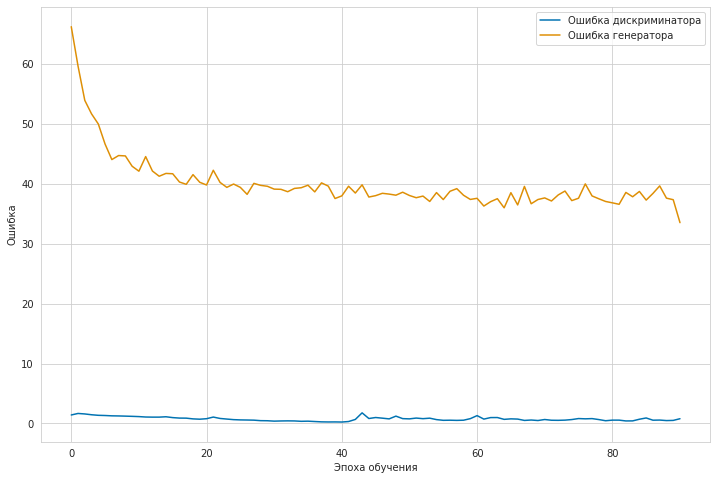

	...epoch 13/100	batch 0/7	D loss: 0.722022	G loss: 38.125805
	...epoch 13/100	batch 1/7	D loss: 0.526887	G loss: 37.775822
	...epoch 13/100	batch 2/7	D loss: 0.480395	G loss: 35.289299
	...epoch 13/100	batch 3/7	D loss: 0.773265	G loss: 39.089890
	...epoch 13/100	batch 4/7	D loss: 0.814255	G loss: 35.902966
	...epoch 13/100	batch 5/7	D loss: 0.517619	G loss: 36.852863
	...epoch 13/100	batch 6/7	D loss: 0.652331	G loss: 38.010052


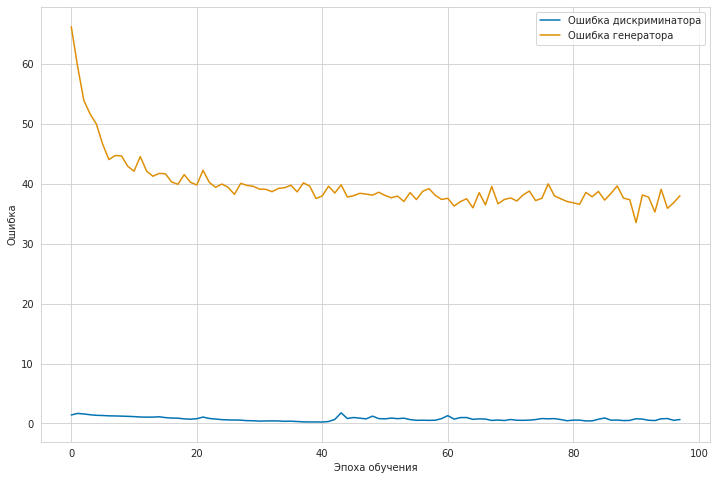

	...epoch 14/100	batch 0/7	D loss: 0.486820	G loss: 37.748928
	...epoch 14/100	batch 1/7	D loss: 0.272136	G loss: 37.784729
	...epoch 14/100	batch 2/7	D loss: 0.408943	G loss: 38.321850
	...epoch 14/100	batch 3/7	D loss: 0.467144	G loss: 36.581585
	...epoch 14/100	batch 4/7	D loss: 0.382408	G loss: 36.852634
	...epoch 14/100	batch 5/7	D loss: 0.402745	G loss: 35.729649
	...epoch 14/100	batch 6/7	D loss: 0.502847	G loss: 37.857861


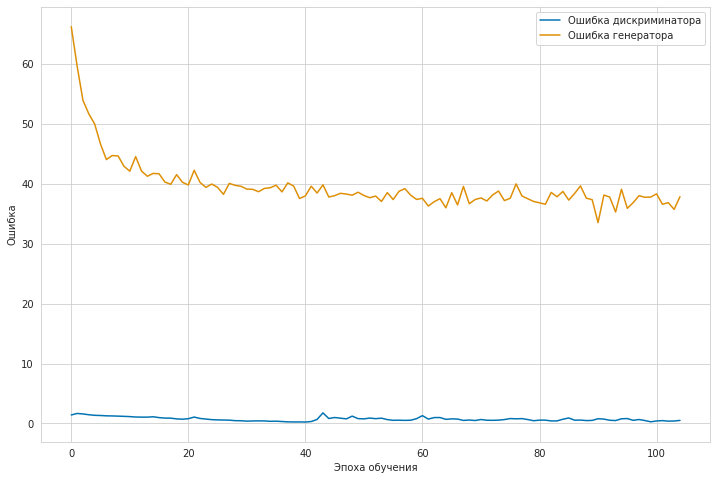

	...epoch 15/100	batch 0/7	D loss: 0.954296	G loss: 36.051491
	...epoch 15/100	batch 1/7	D loss: 0.767824	G loss: 37.633854
	...epoch 15/100	batch 2/7	D loss: 0.551960	G loss: 36.685291
	...epoch 15/100	batch 3/7	D loss: 0.465998	G loss: 34.590244
	...epoch 15/100	batch 4/7	D loss: 0.741935	G loss: 37.336323
	...epoch 15/100	batch 5/7	D loss: 0.789052	G loss: 38.561920
	...epoch 15/100	batch 6/7	D loss: 0.601135	G loss: 35.143734


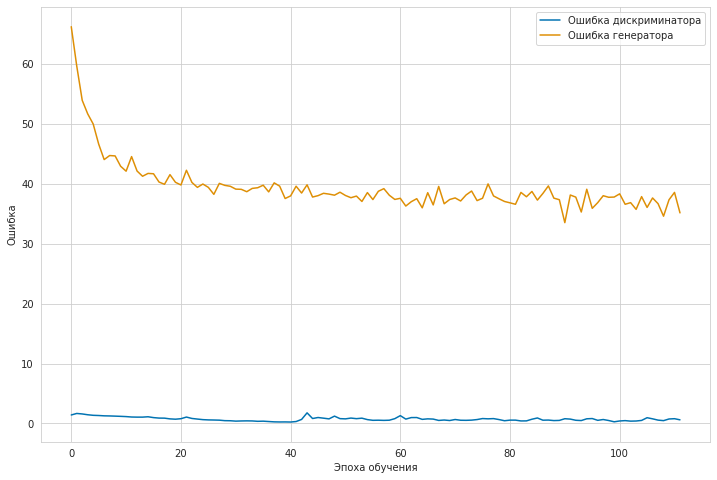

	...epoch 16/100	batch 0/7	D loss: 0.370093	G loss: 37.221066
	...epoch 16/100	batch 1/7	D loss: 0.293636	G loss: 38.598660
	...epoch 16/100	batch 2/7	D loss: 0.452856	G loss: 35.811707
	...epoch 16/100	batch 3/7	D loss: 0.417993	G loss: 35.276379
	...epoch 16/100	batch 4/7	D loss: 0.513806	G loss: 37.577976
	...epoch 16/100	batch 5/7	D loss: 0.868889	G loss: 35.903008
	...epoch 16/100	batch 6/7	D loss: 0.545715	G loss: 36.961754


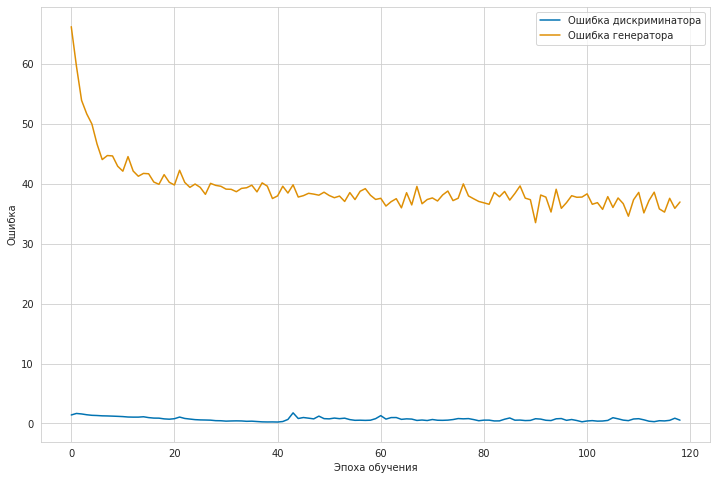

	...epoch 17/100	batch 0/7	D loss: 0.372743	G loss: 37.181206
	...epoch 17/100	batch 1/7	D loss: 0.414450	G loss: 37.275295
	...epoch 17/100	batch 2/7	D loss: 0.456419	G loss: 34.004299
	...epoch 17/100	batch 3/7	D loss: 0.787576	G loss: 37.450577
	...epoch 17/100	batch 4/7	D loss: 0.898025	G loss: 37.211231
	...epoch 17/100	batch 5/7	D loss: 0.781886	G loss: 37.685715
	...epoch 17/100	batch 6/7	D loss: 0.821539	G loss: 37.478218


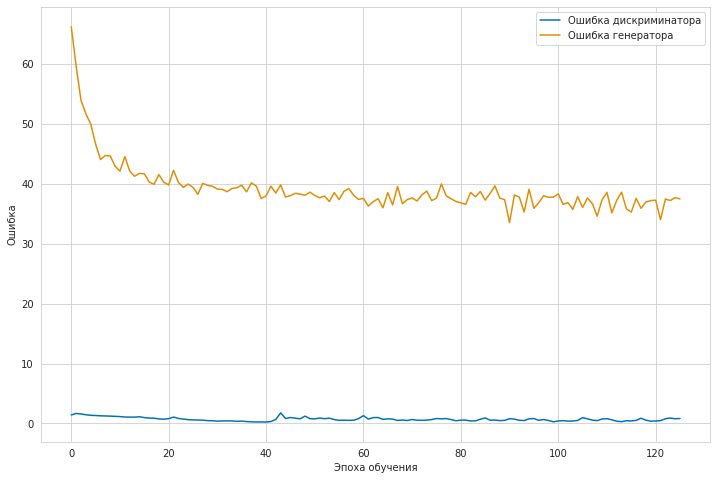

	...epoch 18/100	batch 0/7	D loss: 0.860993	G loss: 35.352253
	...epoch 18/100	batch 1/7	D loss: 0.746578	G loss: 34.771751
	...epoch 18/100	batch 2/7	D loss: 0.483152	G loss: 37.513393
	...epoch 18/100	batch 3/7	D loss: 0.436628	G loss: 36.919388
	...epoch 18/100	batch 4/7	D loss: 0.476938	G loss: 35.297649
	...epoch 18/100	batch 5/7	D loss: 0.338939	G loss: 36.490383
	...epoch 18/100	batch 6/7	D loss: 0.418791	G loss: 33.795132


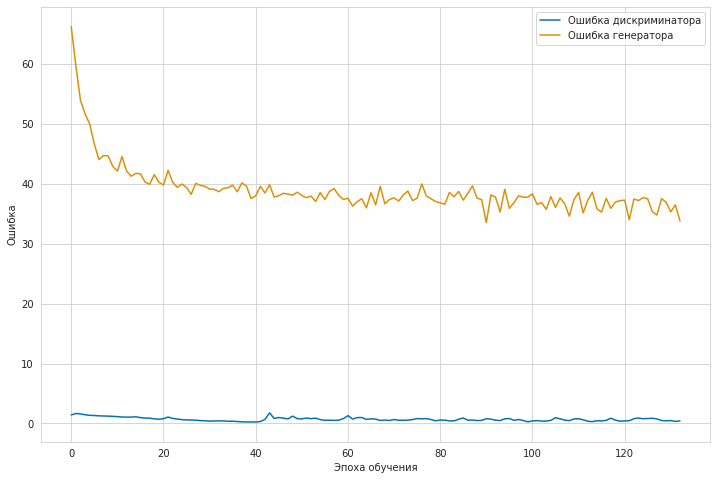

	...epoch 19/100	batch 0/7	D loss: 1.009965	G loss: 37.825115
	...epoch 19/100	batch 1/7	D loss: 1.899053	G loss: 35.702206
	...epoch 19/100	batch 2/7	D loss: 0.795484	G loss: 34.623100
	...epoch 19/100	batch 3/7	D loss: 1.070345	G loss: 34.009251
	...epoch 19/100	batch 4/7	D loss: 0.764517	G loss: 35.548233
	...epoch 19/100	batch 5/7	D loss: 0.976659	G loss: 33.940311
	...epoch 19/100	batch 6/7	D loss: 0.646443	G loss: 34.255493


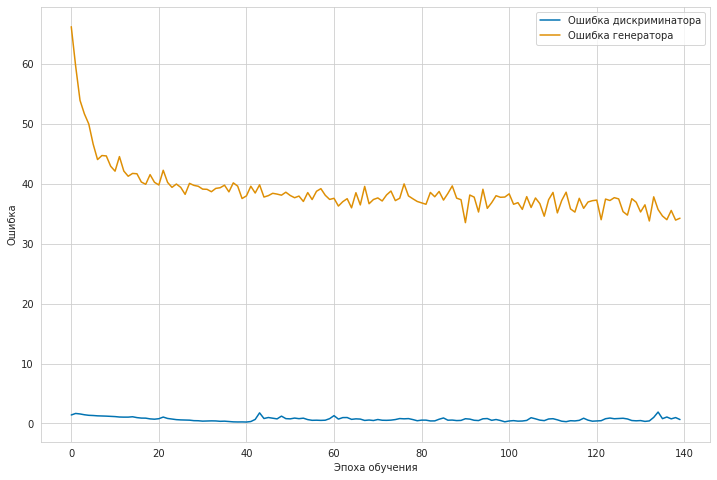

	...epoch 20/100	batch 0/7	D loss: 0.385153	G loss: 34.884598
	...epoch 20/100	batch 1/7	D loss: 0.520745	G loss: 35.543415
	...epoch 20/100	batch 2/7	D loss: 0.518957	G loss: 33.406101
	...epoch 20/100	batch 3/7	D loss: 0.562380	G loss: 36.628513
	...epoch 20/100	batch 4/7	D loss: 0.399245	G loss: 34.741943
	...epoch 20/100	batch 5/7	D loss: 0.334157	G loss: 37.022869
	...epoch 20/100	batch 6/7	D loss: 0.453042	G loss: 34.336452


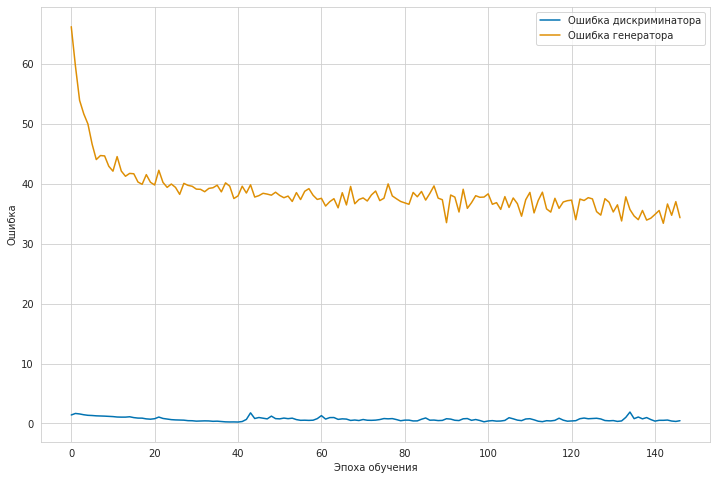

	...epoch 21/100	batch 0/7	D loss: 0.347616	G loss: 37.398285
	...epoch 21/100	batch 1/7	D loss: 0.269034	G loss: 34.328609
	...epoch 21/100	batch 2/7	D loss: 0.292345	G loss: 36.674377
	...epoch 21/100	batch 3/7	D loss: 0.259977	G loss: 35.706627
	...epoch 21/100	batch 4/7	D loss: 0.229472	G loss: 36.707756
	...epoch 21/100	batch 5/7	D loss: 0.266273	G loss: 36.128342
	...epoch 21/100	batch 6/7	D loss: 0.282876	G loss: 36.182358


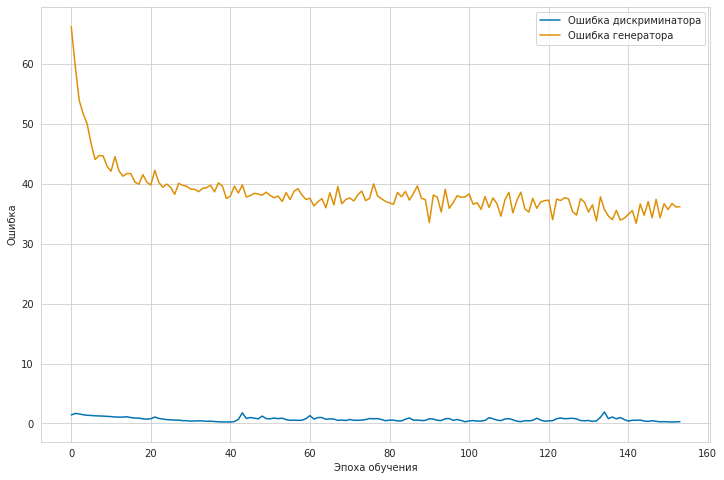

	...epoch 22/100	batch 0/7	D loss: 0.362452	G loss: 36.207020
	...epoch 22/100	batch 1/7	D loss: 0.502851	G loss: 35.207050
	...epoch 22/100	batch 2/7	D loss: 0.875526	G loss: 32.557606
	...epoch 22/100	batch 3/7	D loss: 1.011100	G loss: 35.086430
	...epoch 22/100	batch 4/7	D loss: 0.758789	G loss: 33.438091
	...epoch 22/100	batch 5/7	D loss: 0.876696	G loss: 34.923866
	...epoch 22/100	batch 6/7	D loss: 0.457537	G loss: 37.094364


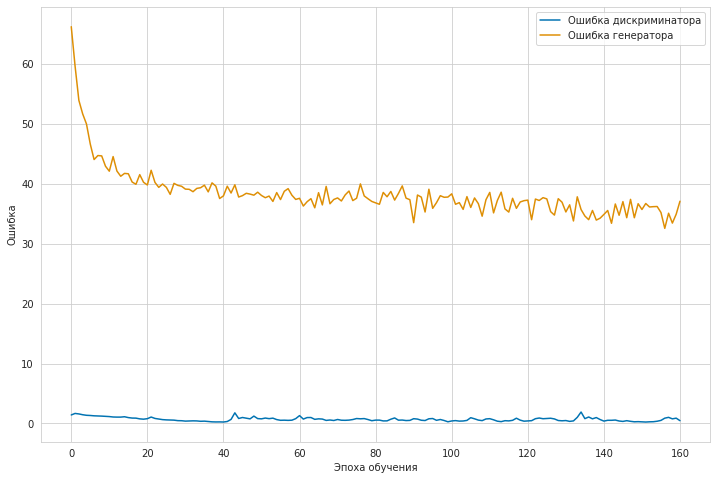

	...epoch 23/100	batch 0/7	D loss: 0.525260	G loss: 33.896309
	...epoch 23/100	batch 1/7	D loss: 0.891043	G loss: 33.715034
	...epoch 23/100	batch 2/7	D loss: 0.611367	G loss: 33.731472
	...epoch 23/100	batch 3/7	D loss: 0.510026	G loss: 34.596489
	...epoch 23/100	batch 4/7	D loss: 0.403755	G loss: 34.600441
	...epoch 23/100	batch 5/7	D loss: 0.463987	G loss: 34.619541
	...epoch 23/100	batch 6/7	D loss: 0.458778	G loss: 35.762207


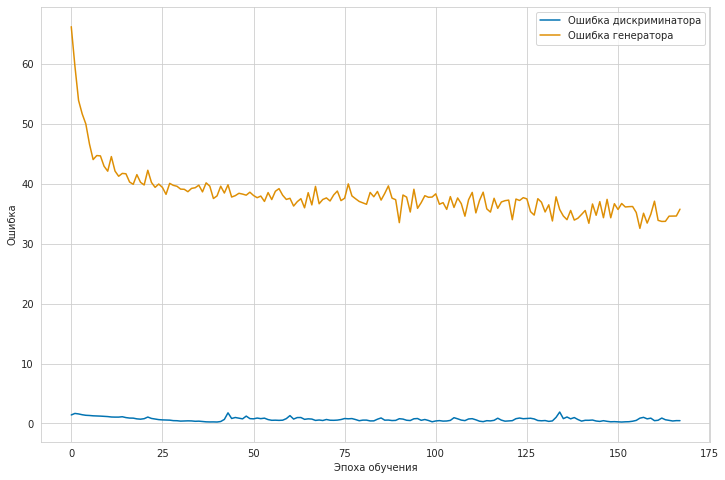

	...epoch 24/100	batch 0/7	D loss: 0.534231	G loss: 34.034889
	...epoch 24/100	batch 1/7	D loss: 0.450234	G loss: 34.289429
	...epoch 24/100	batch 2/7	D loss: 0.534792	G loss: 34.209751
	...epoch 24/100	batch 3/7	D loss: 0.837220	G loss: 32.700588
	...epoch 24/100	batch 4/7	D loss: 0.578657	G loss: 36.126144
	...epoch 24/100	batch 5/7	D loss: 0.389868	G loss: 32.859287
	...epoch 24/100	batch 6/7	D loss: 0.497238	G loss: 36.046139


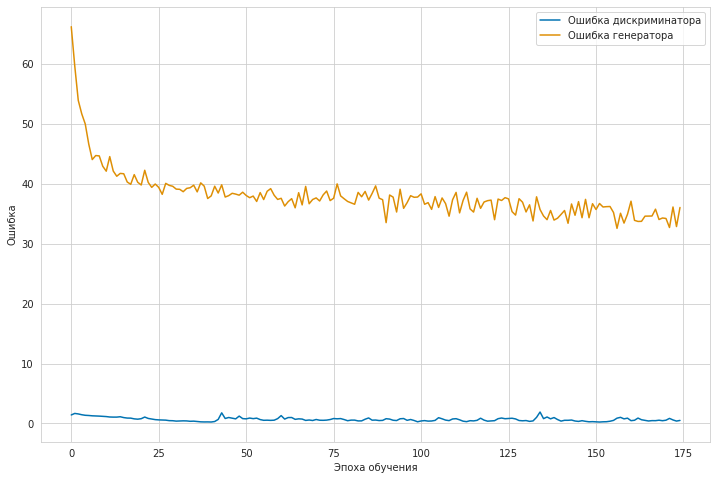

	...epoch 25/100	batch 0/7	D loss: 0.739919	G loss: 39.739784
	...epoch 25/100	batch 1/7	D loss: 1.593847	G loss: 32.957504
	...epoch 25/100	batch 2/7	D loss: 1.008571	G loss: 32.252483
	...epoch 25/100	batch 3/7	D loss: 0.800752	G loss: 34.686108
	...epoch 25/100	batch 4/7	D loss: 0.605393	G loss: 33.065399
	...epoch 25/100	batch 5/7	D loss: 0.393079	G loss: 30.513123
	...epoch 25/100	batch 6/7	D loss: 0.916485	G loss: 33.189930


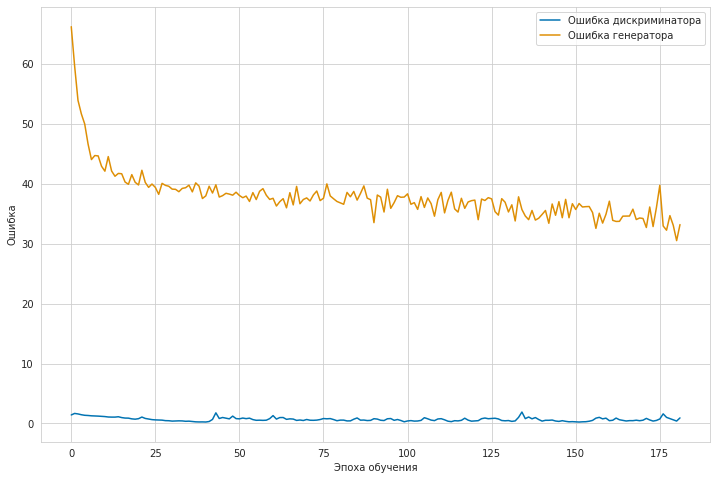

	...epoch 26/100	batch 0/7	D loss: 1.152185	G loss: 32.436104
	...epoch 26/100	batch 1/7	D loss: 0.397458	G loss: 30.981361
	...epoch 26/100	batch 2/7	D loss: 0.579943	G loss: 33.626617
	...epoch 26/100	batch 3/7	D loss: 0.415442	G loss: 32.044262
	...epoch 26/100	batch 4/7	D loss: 0.384898	G loss: 32.541523
	...epoch 26/100	batch 5/7	D loss: 0.376292	G loss: 34.914139
	...epoch 26/100	batch 6/7	D loss: 0.400302	G loss: 32.208973


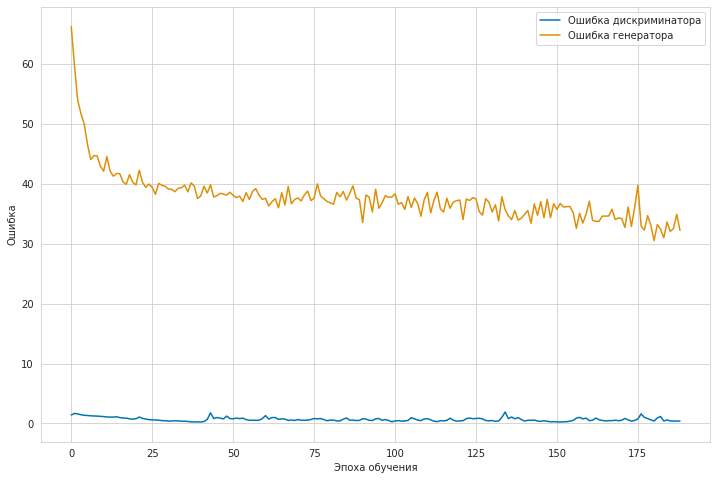

	...epoch 27/100	batch 0/7	D loss: 0.569793	G loss: 33.199928
	...epoch 27/100	batch 1/7	D loss: 0.840637	G loss: 30.416628
	...epoch 27/100	batch 2/7	D loss: 0.469923	G loss: 31.861494
	...epoch 27/100	batch 3/7	D loss: 0.385235	G loss: 32.497383
	...epoch 27/100	batch 4/7	D loss: 0.399616	G loss: 32.899372
	...epoch 27/100	batch 5/7	D loss: 0.486152	G loss: 32.422020
	...epoch 27/100	batch 6/7	D loss: 0.687043	G loss: 33.509056


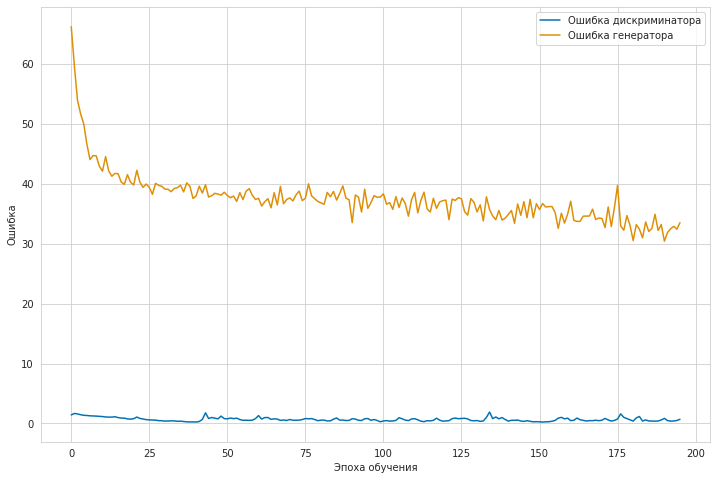

	...epoch 28/100	batch 0/7	D loss: 1.339961	G loss: 31.400236
	...epoch 28/100	batch 1/7	D loss: 0.384930	G loss: 31.585602
	...epoch 28/100	batch 2/7	D loss: 0.805939	G loss: 34.322063
	...epoch 28/100	batch 3/7	D loss: 0.658198	G loss: 32.214249
	...epoch 28/100	batch 4/7	D loss: 0.481129	G loss: 31.174358
	...epoch 28/100	batch 5/7	D loss: 0.679905	G loss: 33.177204
	...epoch 28/100	batch 6/7	D loss: 1.443655	G loss: 29.924551


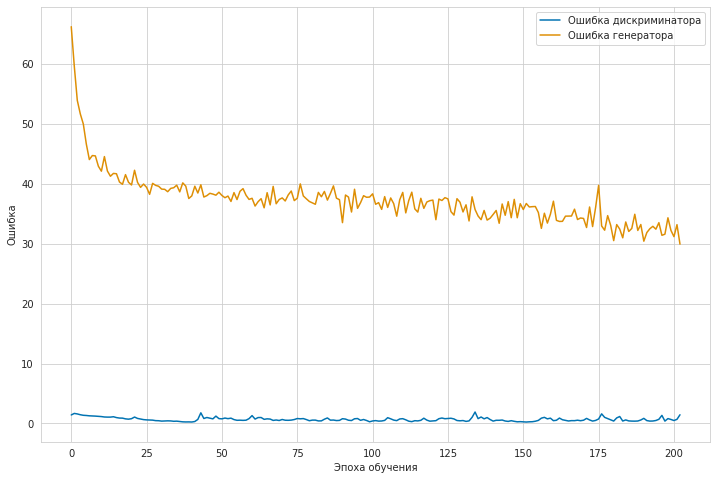

	...epoch 29/100	batch 0/7	D loss: 0.596772	G loss: 30.262926
	...epoch 29/100	batch 1/7	D loss: 0.684759	G loss: 31.009426
	...epoch 29/100	batch 2/7	D loss: 0.572790	G loss: 30.419649
	...epoch 29/100	batch 3/7	D loss: 0.557458	G loss: 32.993340
	...epoch 29/100	batch 4/7	D loss: 0.578589	G loss: 31.059147
	...epoch 29/100	batch 5/7	D loss: 0.394663	G loss: 30.875881
	...epoch 29/100	batch 6/7	D loss: 0.482603	G loss: 31.654888


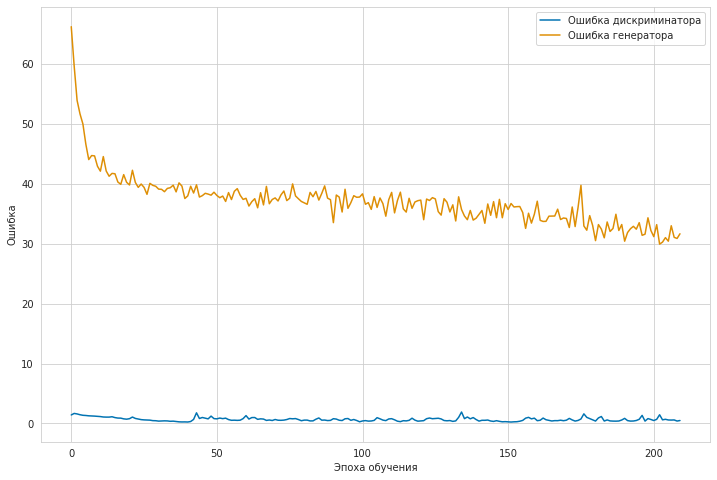

	...epoch 30/100	batch 0/7	D loss: 0.500455	G loss: 30.490602
	...epoch 30/100	batch 1/7	D loss: 0.538492	G loss: 32.620213
	...epoch 30/100	batch 2/7	D loss: 1.033227	G loss: 29.449650
	...epoch 30/100	batch 3/7	D loss: 0.727744	G loss: 31.023556
	...epoch 30/100	batch 4/7	D loss: 0.501892	G loss: 29.456257
	...epoch 30/100	batch 5/7	D loss: 0.612133	G loss: 30.466587
	...epoch 30/100	batch 6/7	D loss: 0.344672	G loss: 33.102589


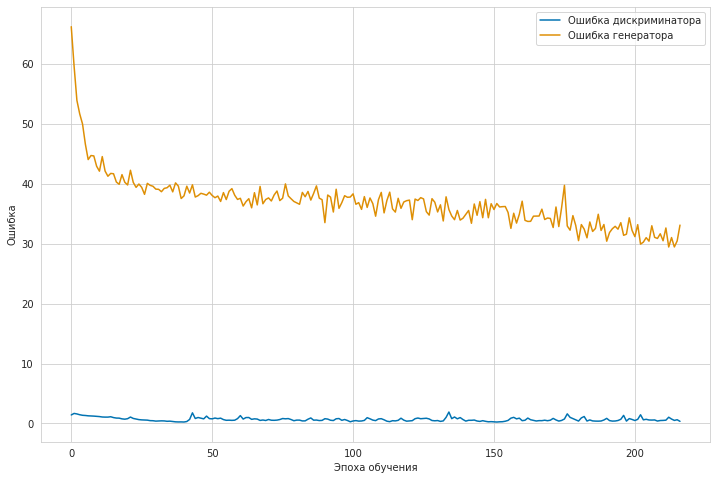

	...epoch 31/100	batch 0/7	D loss: 0.421017	G loss: 31.258720
	...epoch 31/100	batch 1/7	D loss: 0.499834	G loss: 29.954662
	...epoch 31/100	batch 2/7	D loss: 0.799191	G loss: 32.050678
	...epoch 31/100	batch 3/7	D loss: 1.225971	G loss: 29.672483
	...epoch 31/100	batch 4/7	D loss: 0.751320	G loss: 31.240650
	...epoch 31/100	batch 5/7	D loss: 0.729954	G loss: 28.392189
	...epoch 31/100	batch 6/7	D loss: 0.423673	G loss: 31.706896


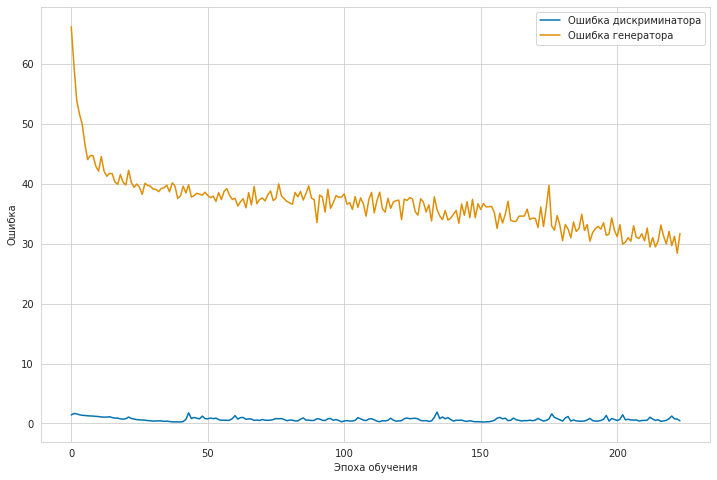

	...epoch 32/100	batch 0/7	D loss: 0.575713	G loss: 31.749924
	...epoch 32/100	batch 1/7	D loss: 0.458957	G loss: 31.376549
	...epoch 32/100	batch 2/7	D loss: 0.772801	G loss: 33.501530
	...epoch 32/100	batch 3/7	D loss: 1.156435	G loss: 28.533915
	...epoch 32/100	batch 4/7	D loss: 0.548436	G loss: 28.576565
	...epoch 32/100	batch 5/7	D loss: 0.555585	G loss: 29.430408
	...epoch 32/100	batch 6/7	D loss: 0.513076	G loss: 28.975243


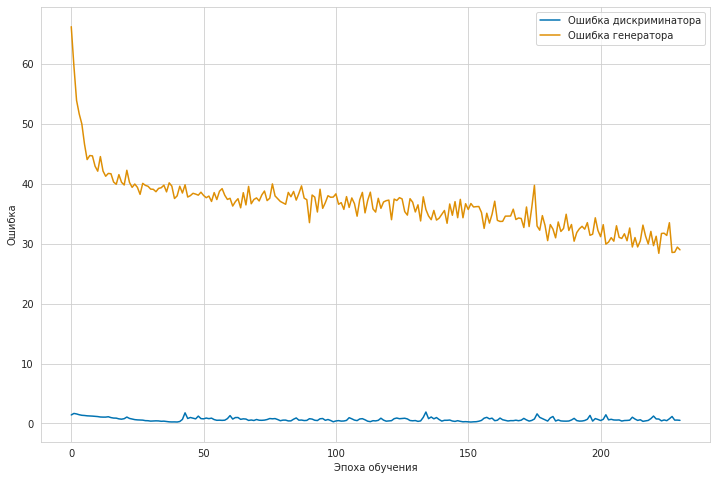

	...epoch 33/100	batch 0/7	D loss: 1.376990	G loss: 30.389837
	...epoch 33/100	batch 1/7	D loss: 1.667902	G loss: 30.182697
	...epoch 33/100	batch 2/7	D loss: 0.751722	G loss: 27.594702
	...epoch 33/100	batch 3/7	D loss: 0.906824	G loss: 27.432867
	...epoch 33/100	batch 4/7	D loss: 0.802923	G loss: 27.803900
	...epoch 33/100	batch 5/7	D loss: 0.461730	G loss: 29.342302
	...epoch 33/100	batch 6/7	D loss: 1.046319	G loss: 31.415516


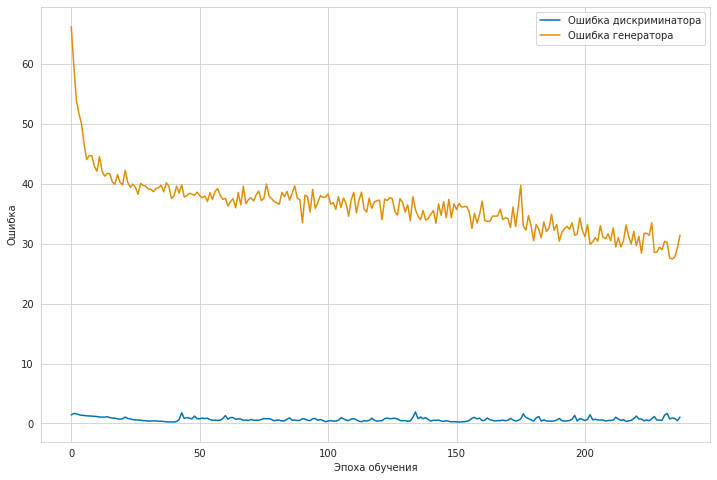

	...epoch 34/100	batch 0/7	D loss: 0.896112	G loss: 30.398333
	...epoch 34/100	batch 1/7	D loss: 0.722653	G loss: 25.948484
	...epoch 34/100	batch 2/7	D loss: 0.690631	G loss: 28.191917
	...epoch 34/100	batch 3/7	D loss: 0.329612	G loss: 29.601030
	...epoch 34/100	batch 4/7	D loss: 0.300187	G loss: 28.748636
	...epoch 34/100	batch 5/7	D loss: 0.471559	G loss: 29.273457
	...epoch 34/100	batch 6/7	D loss: 0.608316	G loss: 27.039679


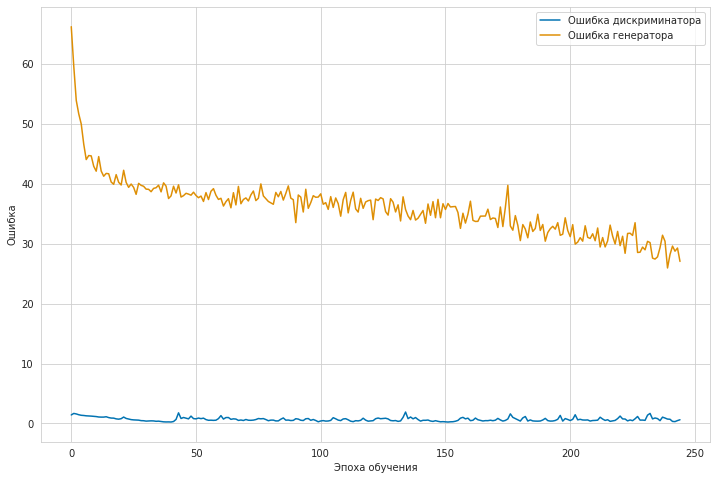

	...epoch 35/100	batch 0/7	D loss: 0.528357	G loss: 28.481705
	...epoch 35/100	batch 1/7	D loss: 0.477196	G loss: 28.311964
	...epoch 35/100	batch 2/7	D loss: 0.540805	G loss: 28.466372
	...epoch 35/100	batch 3/7	D loss: 0.738091	G loss: 27.353394
	...epoch 35/100	batch 4/7	D loss: 0.711411	G loss: 29.251492
	...epoch 35/100	batch 5/7	D loss: 0.609491	G loss: 28.865118
	...epoch 35/100	batch 6/7	D loss: 0.992293	G loss: 28.105211


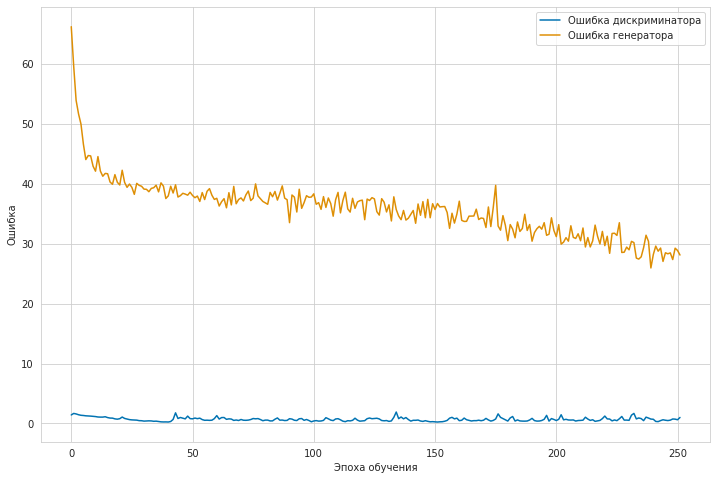

	...epoch 36/100	batch 0/7	D loss: 0.944220	G loss: 26.694563
	...epoch 36/100	batch 1/7	D loss: 0.587498	G loss: 28.403122
	...epoch 36/100	batch 2/7	D loss: 0.601057	G loss: 27.304249
	...epoch 36/100	batch 3/7	D loss: 0.502256	G loss: 27.602106
	...epoch 36/100	batch 4/7	D loss: 1.024859	G loss: 28.725973
	...epoch 36/100	batch 5/7	D loss: 1.475497	G loss: 26.400869
	...epoch 36/100	batch 6/7	D loss: 0.535447	G loss: 26.525946


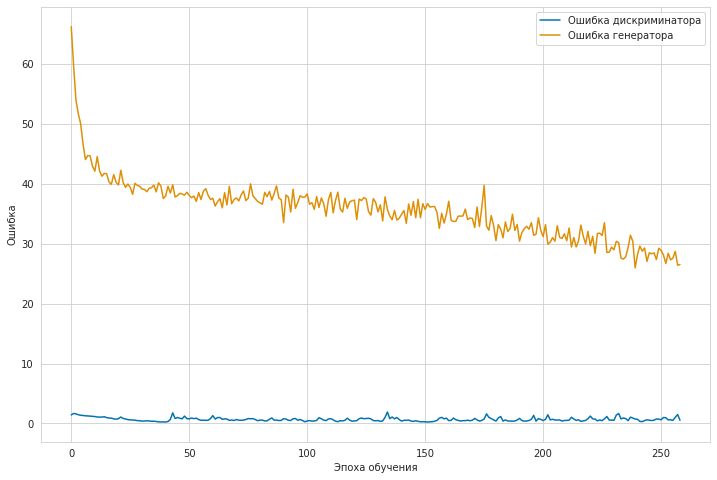

	...epoch 37/100	batch 0/7	D loss: 0.599822	G loss: 27.218555
	...epoch 37/100	batch 1/7	D loss: 0.398355	G loss: 27.681141
	...epoch 37/100	batch 2/7	D loss: 0.594410	G loss: 26.951542
	...epoch 37/100	batch 3/7	D loss: 0.568735	G loss: 26.995630
	...epoch 37/100	batch 4/7	D loss: 0.780994	G loss: 26.271780
	...epoch 37/100	batch 5/7	D loss: 0.850662	G loss: 26.364000
	...epoch 37/100	batch 6/7	D loss: 0.607417	G loss: 28.336975


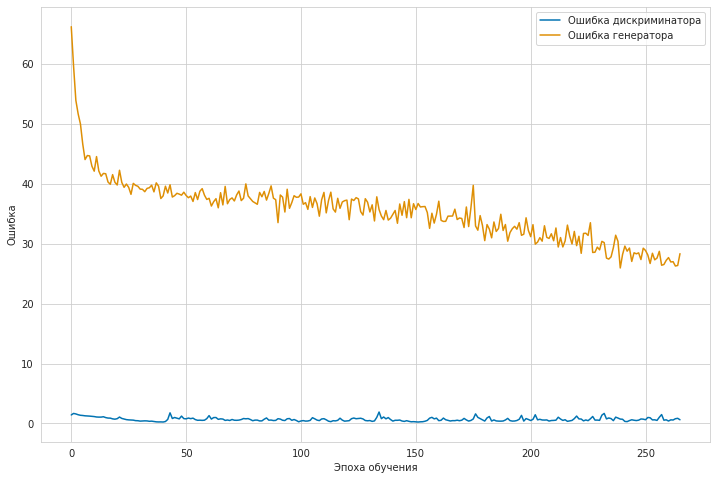

	...epoch 38/100	batch 0/7	D loss: 0.921215	G loss: 26.720232
	...epoch 38/100	batch 1/7	D loss: 0.714769	G loss: 26.661015
	...epoch 38/100	batch 2/7	D loss: 0.612182	G loss: 27.100645
	...epoch 38/100	batch 3/7	D loss: 0.769361	G loss: 26.732101
	...epoch 38/100	batch 4/7	D loss: 0.961350	G loss: 27.236080
	...epoch 38/100	batch 5/7	D loss: 1.068293	G loss: 27.383917
	...epoch 38/100	batch 6/7	D loss: 1.083471	G loss: 24.215900


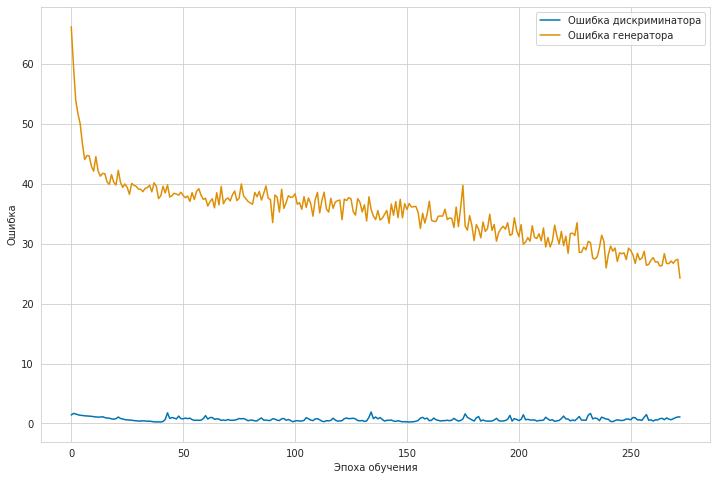

	...epoch 39/100	batch 0/7	D loss: 2.058394	G loss: 28.785305
	...epoch 39/100	batch 1/7	D loss: 1.879775	G loss: 24.156862
	...epoch 39/100	batch 2/7	D loss: 0.996239	G loss: 24.597477
	...epoch 39/100	batch 3/7	D loss: 0.932335	G loss: 23.596497
	...epoch 39/100	batch 4/7	D loss: 0.707923	G loss: 23.759840
	...epoch 39/100	batch 5/7	D loss: 0.890472	G loss: 25.748367
	...epoch 39/100	batch 6/7	D loss: 0.926688	G loss: 26.717766


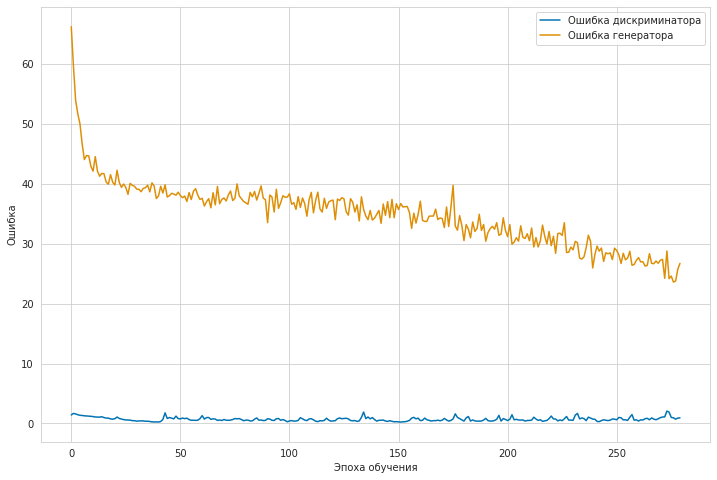

	...epoch 40/100	batch 0/7	D loss: 0.654241	G loss: 24.868311
	...epoch 40/100	batch 1/7	D loss: 0.556072	G loss: 25.147802
	...epoch 40/100	batch 2/7	D loss: 0.462651	G loss: 26.140423
	...epoch 40/100	batch 3/7	D loss: 0.599521	G loss: 24.907097
	...epoch 40/100	batch 4/7	D loss: 0.778014	G loss: 26.904224
	...epoch 40/100	batch 5/7	D loss: 0.903174	G loss: 25.649927
	...epoch 40/100	batch 6/7	D loss: 0.563634	G loss: 27.034403


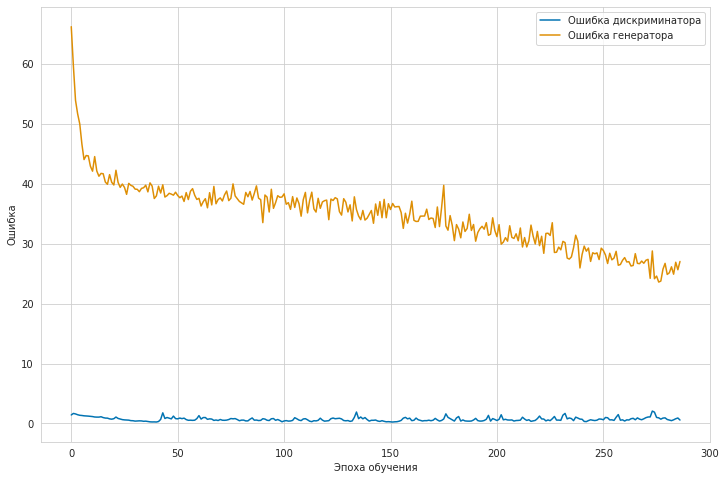

	...epoch 41/100	batch 0/7	D loss: 0.954512	G loss: 26.022038
	...epoch 41/100	batch 1/7	D loss: 0.788731	G loss: 24.104797
	...epoch 41/100	batch 2/7	D loss: 0.772390	G loss: 26.516924
	...epoch 41/100	batch 3/7	D loss: 0.902039	G loss: 24.448231
	...epoch 41/100	batch 4/7	D loss: 0.882277	G loss: 25.883562
	...epoch 41/100	batch 5/7	D loss: 0.864501	G loss: 24.380188
	...epoch 41/100	batch 6/7	D loss: 0.877867	G loss: 26.243349


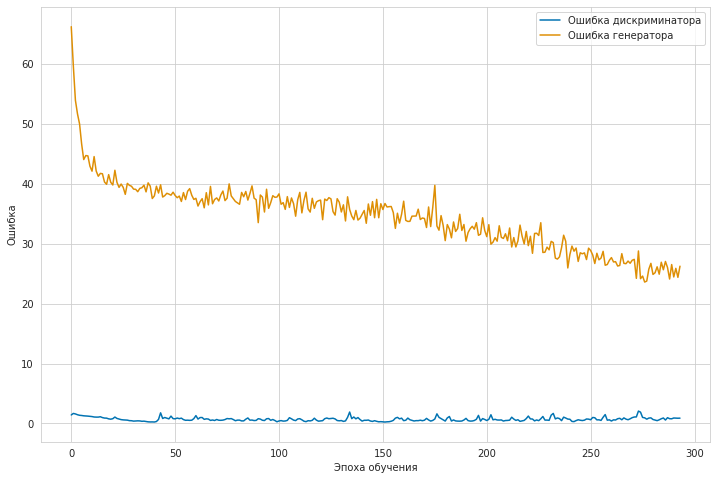

	...epoch 42/100	batch 0/7	D loss: 1.234868	G loss: 24.415791
	...epoch 42/100	batch 1/7	D loss: 0.848530	G loss: 25.543730
	...epoch 42/100	batch 2/7	D loss: 0.681898	G loss: 23.896528
	...epoch 42/100	batch 3/7	D loss: 0.616919	G loss: 25.017305
	...epoch 42/100	batch 4/7	D loss: 0.743345	G loss: 24.460081
	...epoch 42/100	batch 5/7	D loss: 0.812505	G loss: 25.963543
	...epoch 42/100	batch 6/7	D loss: 1.568001	G loss: 23.321823


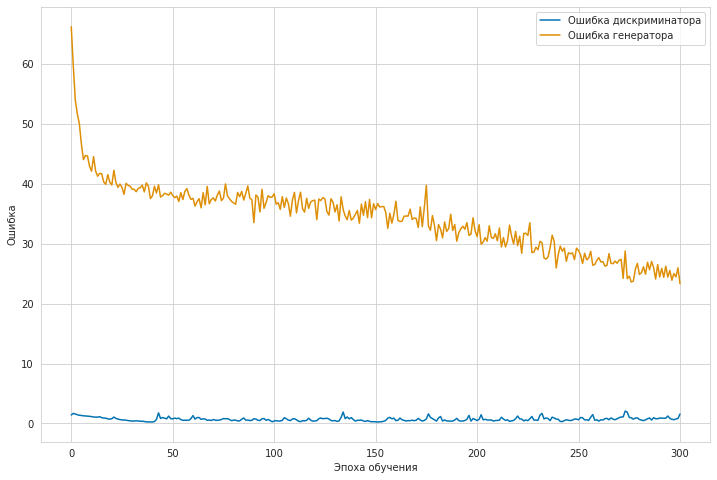

	...epoch 43/100	batch 0/7	D loss: 0.837658	G loss: 26.843407
	...epoch 43/100	batch 1/7	D loss: 0.565913	G loss: 25.447124
	...epoch 43/100	batch 2/7	D loss: 0.726132	G loss: 24.251961
	...epoch 43/100	batch 3/7	D loss: 0.827662	G loss: 24.172220
	...epoch 43/100	batch 4/7	D loss: 0.562829	G loss: 25.107040
	...epoch 43/100	batch 5/7	D loss: 1.168863	G loss: 23.141493
	...epoch 43/100	batch 6/7	D loss: 0.658562	G loss: 23.426096


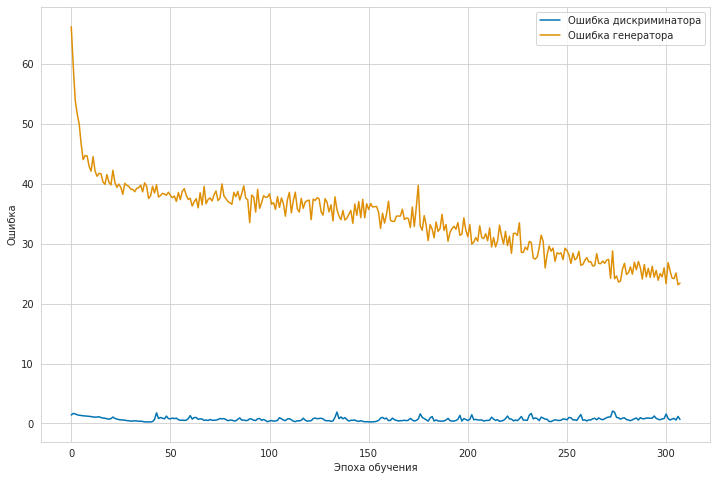

	...epoch 44/100	batch 0/7	D loss: 0.617110	G loss: 24.573309
	...epoch 44/100	batch 1/7	D loss: 0.889100	G loss: 23.546024
	...epoch 44/100	batch 2/7	D loss: 0.839438	G loss: 25.013866
	...epoch 44/100	batch 3/7	D loss: 1.159661	G loss: 22.813267
	...epoch 44/100	batch 4/7	D loss: 0.638039	G loss: 24.331528
	...epoch 44/100	batch 5/7	D loss: 0.621776	G loss: 23.936230
	...epoch 44/100	batch 6/7	D loss: 0.794300	G loss: 26.239159


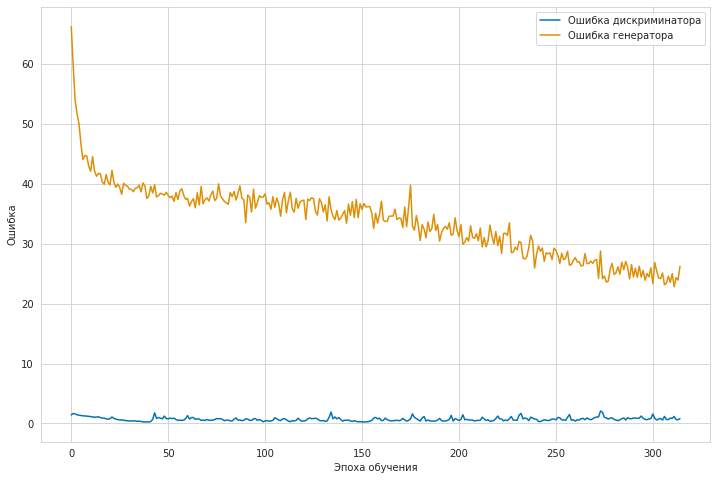

	...epoch 45/100	batch 0/7	D loss: 1.842210	G loss: 22.971537
	...epoch 45/100	batch 1/7	D loss: 0.681414	G loss: 23.348585
	...epoch 45/100	batch 2/7	D loss: 0.880301	G loss: 25.286652
	...epoch 45/100	batch 3/7	D loss: 1.097205	G loss: 22.651363
	...epoch 45/100	batch 4/7	D loss: 0.636088	G loss: 23.871998
	...epoch 45/100	batch 5/7	D loss: 0.911467	G loss: 22.716755
	...epoch 45/100	batch 6/7	D loss: 1.273452	G loss: 27.318930


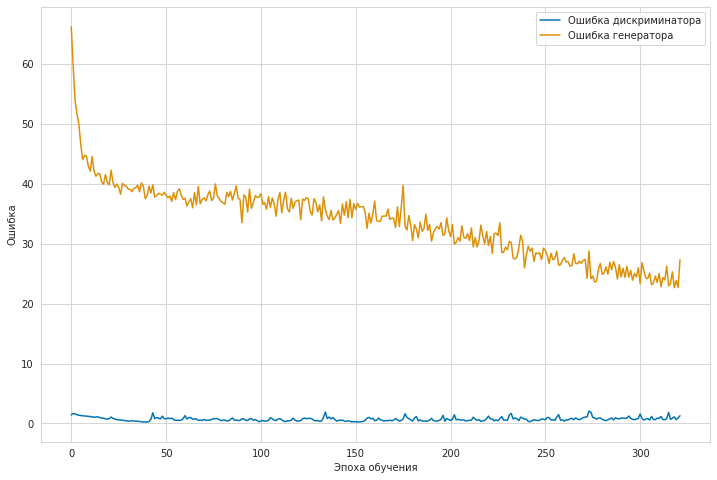

	...epoch 46/100	batch 0/7	D loss: 1.831706	G loss: 26.215986
	...epoch 46/100	batch 1/7	D loss: 0.750767	G loss: 24.120592
	...epoch 46/100	batch 2/7	D loss: 0.787360	G loss: 25.379673
	...epoch 46/100	batch 3/7	D loss: 0.662124	G loss: 23.780975
	...epoch 46/100	batch 4/7	D loss: 0.906507	G loss: 22.999680
	...epoch 46/100	batch 5/7	D loss: 0.812274	G loss: 22.606195
	...epoch 46/100	batch 6/7	D loss: 0.644003	G loss: 24.604807


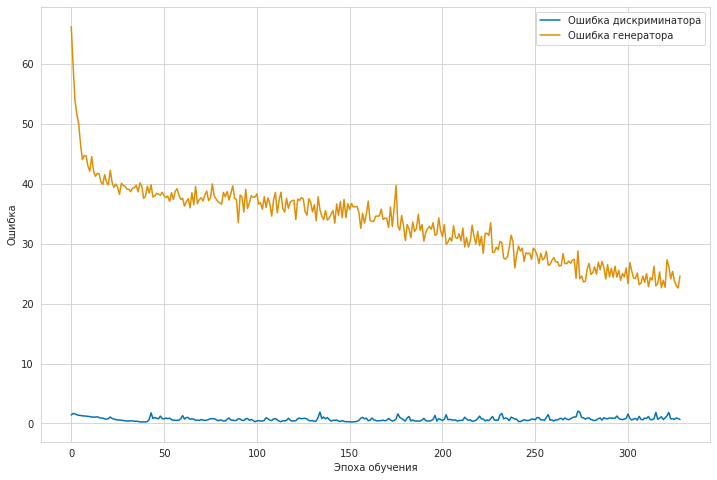

	...epoch 47/100	batch 0/7	D loss: 0.619412	G loss: 25.736866
	...epoch 47/100	batch 1/7	D loss: 0.881487	G loss: 24.865351
	...epoch 47/100	batch 2/7	D loss: 0.788350	G loss: 23.138186
	...epoch 47/100	batch 3/7	D loss: 0.758032	G loss: 22.170006
	...epoch 47/100	batch 4/7	D loss: 0.895724	G loss: 23.597813
	...epoch 47/100	batch 5/7	D loss: 0.965392	G loss: 22.678606
	...epoch 47/100	batch 6/7	D loss: 0.575427	G loss: 23.238125


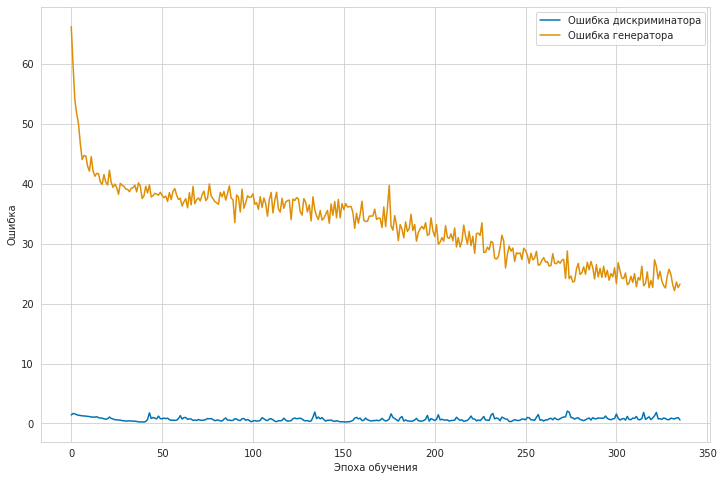

	...epoch 48/100	batch 0/7	D loss: 0.762162	G loss: 24.112614
	...epoch 48/100	batch 1/7	D loss: 0.977633	G loss: 23.546955
	...epoch 48/100	batch 2/7	D loss: 1.303493	G loss: 23.727283
	...epoch 48/100	batch 3/7	D loss: 0.863285	G loss: 22.259659
	...epoch 48/100	batch 4/7	D loss: 0.969553	G loss: 24.085434
	...epoch 48/100	batch 5/7	D loss: 1.034016	G loss: 22.194601
	...epoch 48/100	batch 6/7	D loss: 0.693756	G loss: 23.403660


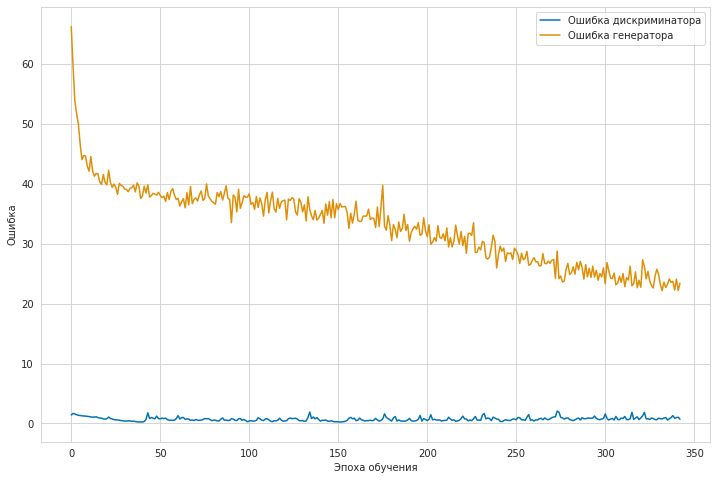

	...epoch 49/100	batch 0/7	D loss: 1.333379	G loss: 24.743275
	...epoch 49/100	batch 1/7	D loss: 1.915661	G loss: 21.521183
	...epoch 49/100	batch 2/7	D loss: 0.854372	G loss: 22.197046
	...epoch 49/100	batch 3/7	D loss: 0.932403	G loss: 22.350519
	...epoch 49/100	batch 4/7	D loss: 0.936105	G loss: 21.333866
	...epoch 49/100	batch 5/7	D loss: 1.037541	G loss: 21.895494
	...epoch 49/100	batch 6/7	D loss: 1.725965	G loss: 23.274250


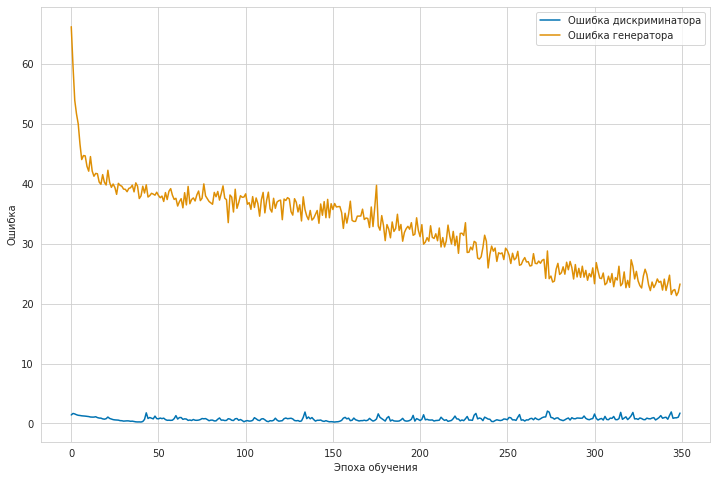

	...epoch 50/100	batch 0/7	D loss: 1.060146	G loss: 21.793236
	...epoch 50/100	batch 1/7	D loss: 1.892150	G loss: 24.791412
	...epoch 50/100	batch 2/7	D loss: 4.554284	G loss: 23.284756
	...epoch 50/100	batch 3/7	D loss: 3.403037	G loss: 21.952299
	...epoch 50/100	batch 4/7	D loss: 1.502341	G loss: 20.935469
	...epoch 50/100	batch 5/7	D loss: 0.853401	G loss: 20.019047
	...epoch 50/100	batch 6/7	D loss: 1.100452	G loss: 21.060337


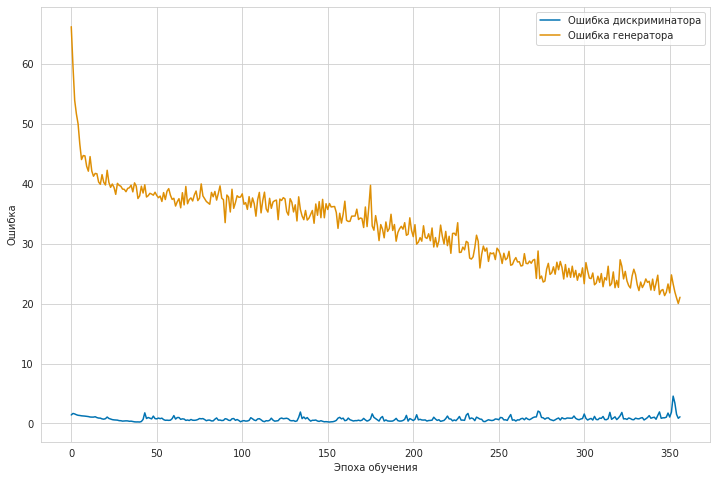

	...epoch 51/100	batch 0/7	D loss: 0.758947	G loss: 21.493284
	...epoch 51/100	batch 1/7	D loss: 0.763880	G loss: 20.646111
	...epoch 51/100	batch 2/7	D loss: 0.610603	G loss: 21.307119
	...epoch 51/100	batch 3/7	D loss: 0.889195	G loss: 22.210089
	...epoch 51/100	batch 4/7	D loss: 0.791014	G loss: 20.864470
	...epoch 51/100	batch 5/7	D loss: 0.785177	G loss: 22.035566
	...epoch 51/100	batch 6/7	D loss: 1.110799	G loss: 20.761597


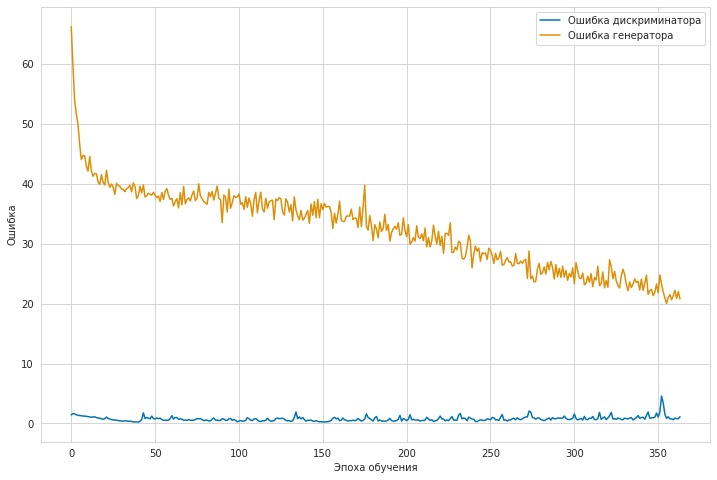

	...epoch 52/100	batch 0/7	D loss: 0.870844	G loss: 21.934370
	...epoch 52/100	batch 1/7	D loss: 0.748474	G loss: 21.665712
	...epoch 52/100	batch 2/7	D loss: 1.146641	G loss: 21.329983
	...epoch 52/100	batch 3/7	D loss: 0.781422	G loss: 20.669886
	...epoch 52/100	batch 4/7	D loss: 0.784449	G loss: 21.746082
	...epoch 52/100	batch 5/7	D loss: 0.995659	G loss: 20.028111
	...epoch 52/100	batch 6/7	D loss: 1.055913	G loss: 21.497778


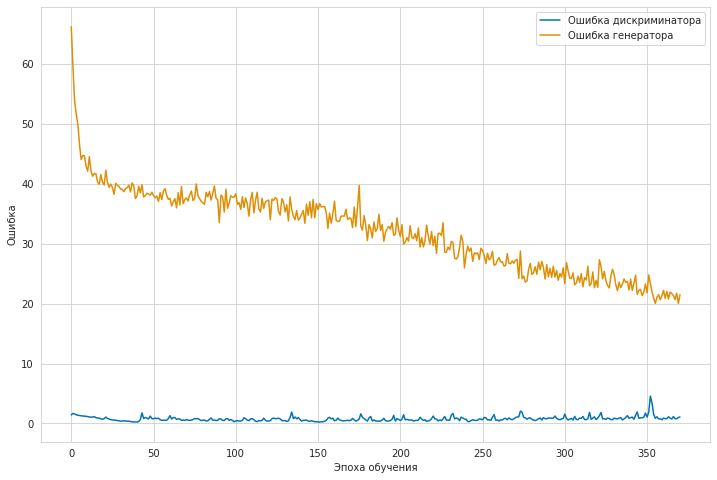

	...epoch 53/100	batch 0/7	D loss: 1.289646	G loss: 22.247366
	...epoch 53/100	batch 1/7	D loss: 1.331019	G loss: 21.214428
	...epoch 53/100	batch 2/7	D loss: 0.580032	G loss: 21.004282
	...epoch 53/100	batch 3/7	D loss: 1.207229	G loss: 21.660793
	...epoch 53/100	batch 4/7	D loss: 1.279496	G loss: 21.764969
	...epoch 53/100	batch 5/7	D loss: 0.815724	G loss: 20.716351
	...epoch 53/100	batch 6/7	D loss: 1.014962	G loss: 23.204569


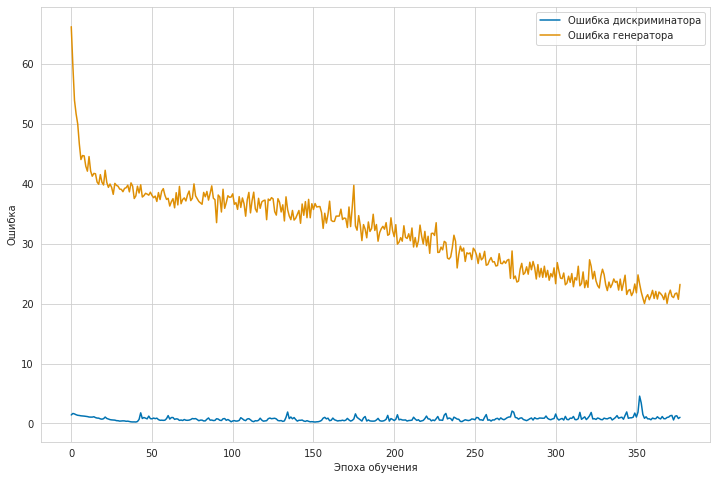

	...epoch 54/100	batch 0/7	D loss: 1.053889	G loss: 21.503740
	...epoch 54/100	batch 1/7	D loss: 1.113052	G loss: 20.321163
	...epoch 54/100	batch 2/7	D loss: 0.679525	G loss: 22.265657
	...epoch 54/100	batch 3/7	D loss: 0.724524	G loss: 20.906313
	...epoch 54/100	batch 4/7	D loss: 0.854460	G loss: 21.931190
	...epoch 54/100	batch 5/7	D loss: 0.952463	G loss: 20.432293
	...epoch 54/100	batch 6/7	D loss: 0.929835	G loss: 23.158331


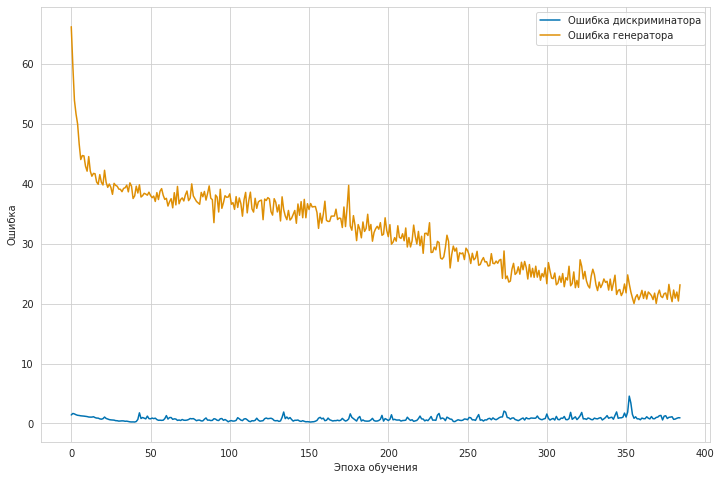

	...epoch 55/100	batch 0/7	D loss: 1.696589	G loss: 21.823107
	...epoch 55/100	batch 1/7	D loss: 0.847242	G loss: 20.310986
	...epoch 55/100	batch 2/7	D loss: 0.871106	G loss: 21.916525
	...epoch 55/100	batch 3/7	D loss: 1.069860	G loss: 19.167574
	...epoch 55/100	batch 4/7	D loss: 0.779005	G loss: 19.370943
	...epoch 55/100	batch 5/7	D loss: 1.116863	G loss: 21.835516
	...epoch 55/100	batch 6/7	D loss: 0.923541	G loss: 22.838110


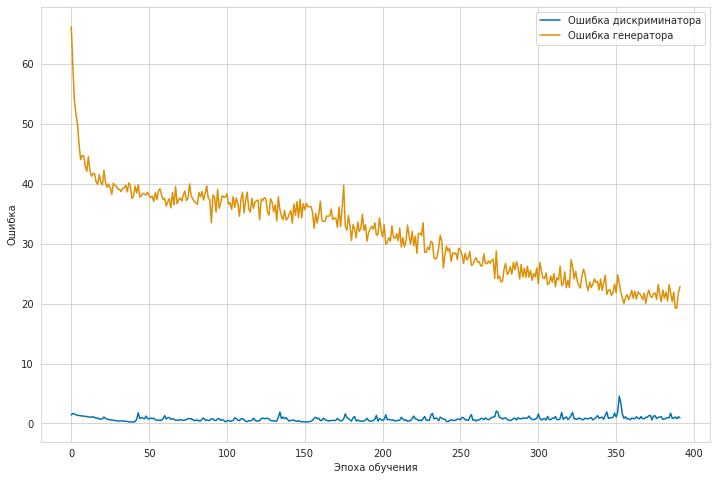

	...epoch 56/100	batch 0/7	D loss: 1.028599	G loss: 21.288675
	...epoch 56/100	batch 1/7	D loss: 0.889787	G loss: 19.873722
	...epoch 56/100	batch 2/7	D loss: 0.758590	G loss: 21.046341
	...epoch 56/100	batch 3/7	D loss: 0.675170	G loss: 20.962286
	...epoch 56/100	batch 4/7	D loss: 1.170280	G loss: 20.410215
	...epoch 56/100	batch 5/7	D loss: 0.773763	G loss: 20.346025
	...epoch 56/100	batch 6/7	D loss: 1.044024	G loss: 21.815510


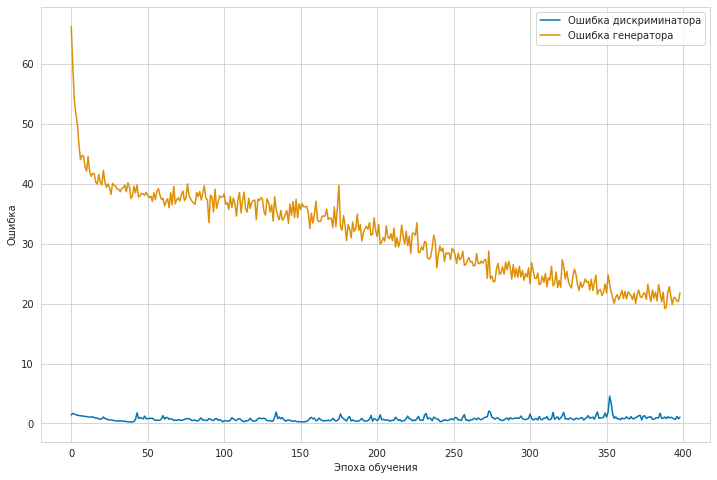

	...epoch 57/100	batch 0/7	D loss: 1.464786	G loss: 20.149431
	...epoch 57/100	batch 1/7	D loss: 0.828664	G loss: 19.633053
	...epoch 57/100	batch 2/7	D loss: 0.842198	G loss: 20.463537
	...epoch 57/100	batch 3/7	D loss: 0.959287	G loss: 20.302776
	...epoch 57/100	batch 4/7	D loss: 1.134735	G loss: 20.414503
	...epoch 57/100	batch 5/7	D loss: 0.718696	G loss: 19.480587
	...epoch 57/100	batch 6/7	D loss: 0.800163	G loss: 21.623190


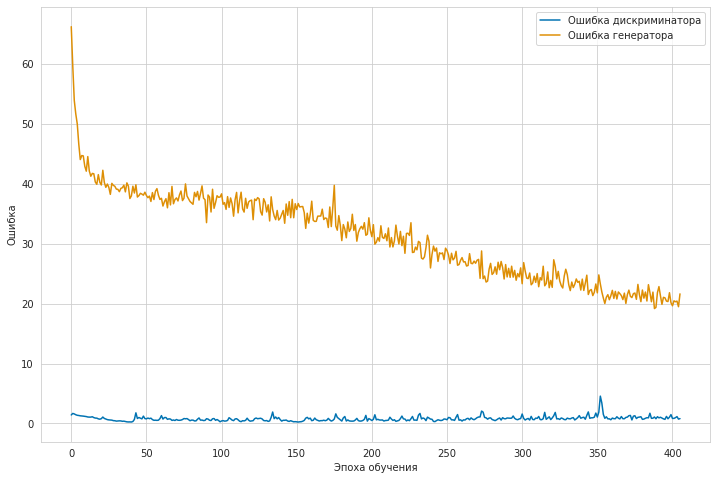

	...epoch 58/100	batch 0/7	D loss: 1.333795	G loss: 19.505671
	...epoch 58/100	batch 1/7	D loss: 0.899124	G loss: 20.338470
	...epoch 58/100	batch 2/7	D loss: 0.933178	G loss: 19.439741
	...epoch 58/100	batch 3/7	D loss: 0.920433	G loss: 21.384001
	...epoch 58/100	batch 4/7	D loss: 1.113387	G loss: 20.404003
	...epoch 58/100	batch 5/7	D loss: 0.815528	G loss: 20.016336
	...epoch 58/100	batch 6/7	D loss: 1.037357	G loss: 18.924009


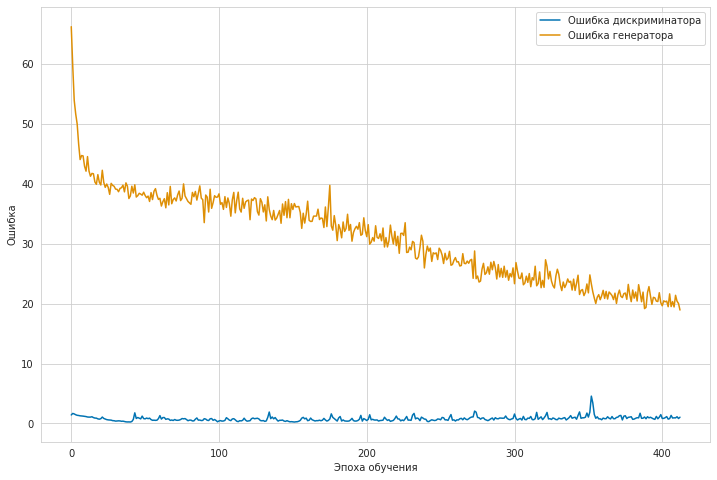

	...epoch 59/100	batch 0/7	D loss: 0.950359	G loss: 20.458790
	...epoch 59/100	batch 1/7	D loss: 1.088903	G loss: 21.714094
	...epoch 59/100	batch 2/7	D loss: 1.328061	G loss: 19.573769
	...epoch 59/100	batch 3/7	D loss: 0.944532	G loss: 21.463993
	...epoch 59/100	batch 4/7	D loss: 0.839289	G loss: 20.142473
	...epoch 59/100	batch 5/7	D loss: 0.833635	G loss: 20.981731
	...epoch 59/100	batch 6/7	D loss: 0.841981	G loss: 20.542723


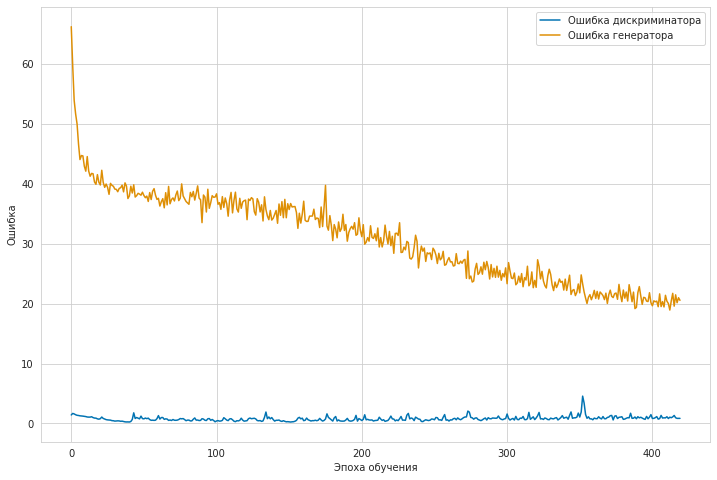

	...epoch 60/100	batch 0/7	D loss: 1.479705	G loss: 21.138710
	...epoch 60/100	batch 1/7	D loss: 1.577225	G loss: 19.442535
	...epoch 60/100	batch 2/7	D loss: 0.943067	G loss: 20.481129
	...epoch 60/100	batch 3/7	D loss: 0.845087	G loss: 19.215715
	...epoch 60/100	batch 4/7	D loss: 0.977507	G loss: 20.433483
	...epoch 60/100	batch 5/7	D loss: 1.219339	G loss: 19.251617
	...epoch 60/100	batch 6/7	D loss: 1.416713	G loss: 21.532251


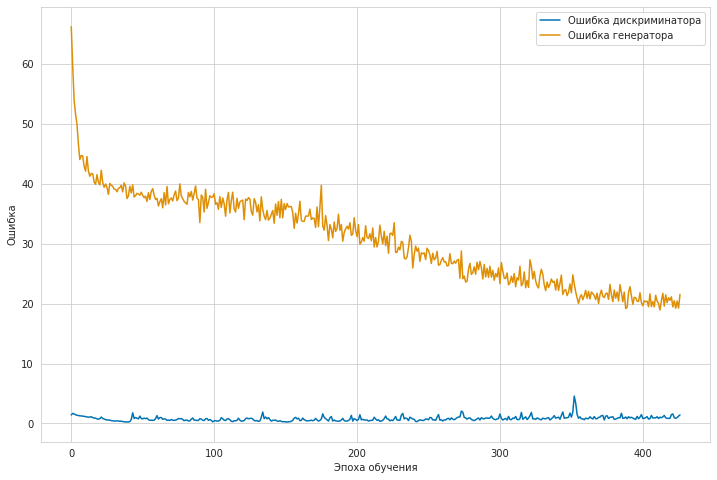

	...epoch 61/100	batch 0/7	D loss: 1.403470	G loss: 18.624138
	...epoch 61/100	batch 1/7	D loss: 0.819321	G loss: 19.365643
	...epoch 61/100	batch 2/7	D loss: 0.976250	G loss: 20.142977
	...epoch 61/100	batch 3/7	D loss: 0.947238	G loss: 19.911768
	...epoch 61/100	batch 4/7	D loss: 0.910710	G loss: 18.924915
	...epoch 61/100	batch 5/7	D loss: 0.888867	G loss: 20.885599
	...epoch 61/100	batch 6/7	D loss: 1.472073	G loss: 21.298376


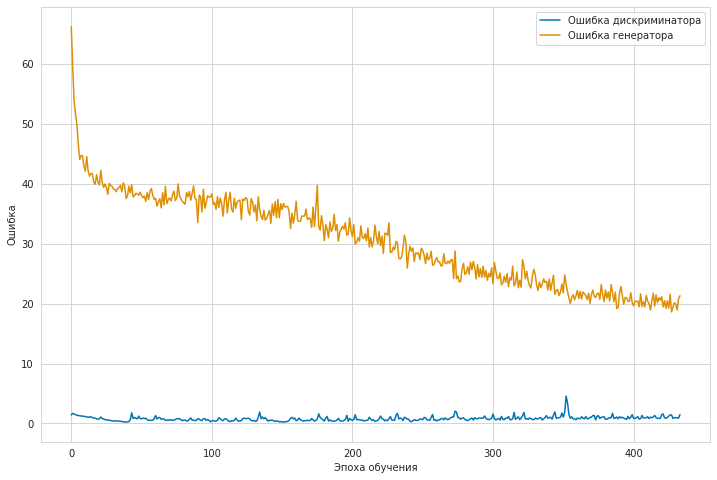

	...epoch 62/100	batch 0/7	D loss: 0.769671	G loss: 20.391838
	...epoch 62/100	batch 1/7	D loss: 1.048520	G loss: 21.280344
	...epoch 62/100	batch 2/7	D loss: 1.055500	G loss: 19.874208
	...epoch 62/100	batch 3/7	D loss: 0.762183	G loss: 18.968935
	...epoch 62/100	batch 4/7	D loss: 0.906534	G loss: 19.949022
	...epoch 62/100	batch 5/7	D loss: 0.875570	G loss: 19.609570
	...epoch 62/100	batch 6/7	D loss: 0.832593	G loss: 19.421106


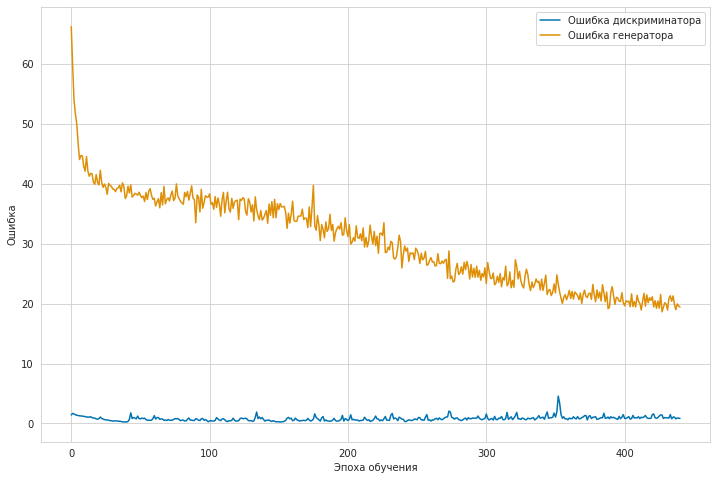

	...epoch 63/100	batch 0/7	D loss: 1.039141	G loss: 19.242643
	...epoch 63/100	batch 1/7	D loss: 0.820061	G loss: 19.388012
	...epoch 63/100	batch 2/7	D loss: 1.285892	G loss: 20.714170
	...epoch 63/100	batch 3/7	D loss: 1.400014	G loss: 20.063932
	...epoch 63/100	batch 4/7	D loss: 0.953735	G loss: 18.851839
	...epoch 63/100	batch 5/7	D loss: 0.922724	G loss: 20.246506
	...epoch 63/100	batch 6/7	D loss: 1.455819	G loss: 18.437792


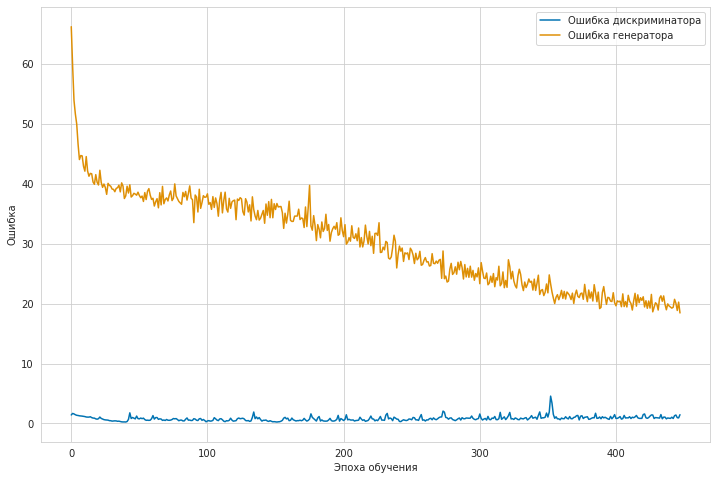

	...epoch 64/100	batch 0/7	D loss: 0.673315	G loss: 19.692001
	...epoch 64/100	batch 1/7	D loss: 1.000955	G loss: 19.907009
	...epoch 64/100	batch 2/7	D loss: 0.844299	G loss: 19.206299
	...epoch 64/100	batch 3/7	D loss: 0.812632	G loss: 19.061295
	...epoch 64/100	batch 4/7	D loss: 0.790976	G loss: 19.103668
	...epoch 64/100	batch 5/7	D loss: 0.700045	G loss: 19.489189
	...epoch 64/100	batch 6/7	D loss: 1.427956	G loss: 23.085871


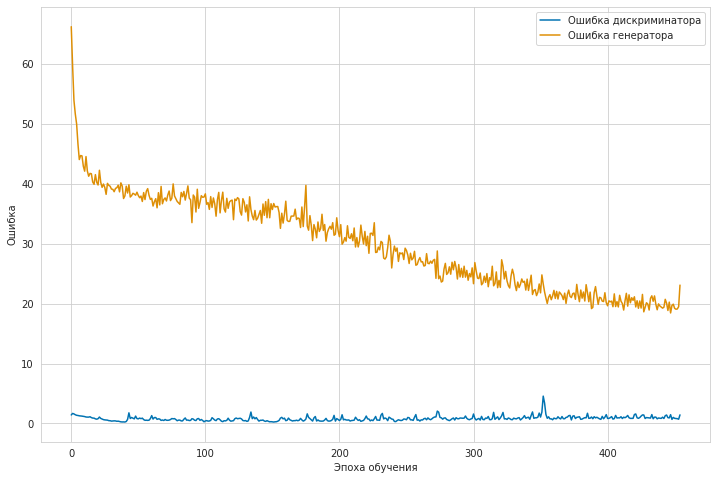

	...epoch 65/100	batch 0/7	D loss: 1.552699	G loss: 20.113537
	...epoch 65/100	batch 1/7	D loss: 0.818853	G loss: 19.524927
	...epoch 65/100	batch 2/7	D loss: 0.970628	G loss: 19.494375
	...epoch 65/100	batch 3/7	D loss: 1.019876	G loss: 19.880581
	...epoch 65/100	batch 4/7	D loss: 1.074124	G loss: 19.002468
	...epoch 65/100	batch 5/7	D loss: 0.882943	G loss: 18.953051
	...epoch 65/100	batch 6/7	D loss: 0.740681	G loss: 20.197115


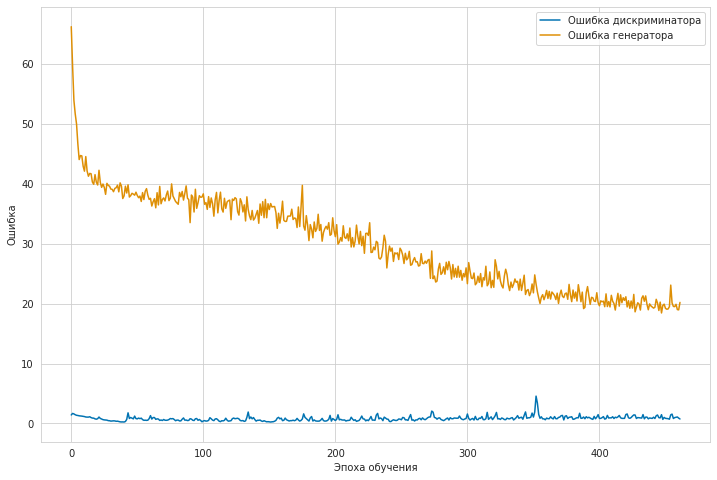

	...epoch 66/100	batch 0/7	D loss: 1.093037	G loss: 19.101799
	...epoch 66/100	batch 1/7	D loss: 1.126197	G loss: 19.609161
	...epoch 66/100	batch 2/7	D loss: 0.817260	G loss: 18.847727
	...epoch 66/100	batch 3/7	D loss: 0.741085	G loss: 19.008535
	...epoch 66/100	batch 4/7	D loss: 1.102144	G loss: 18.703991
	...epoch 66/100	batch 5/7	D loss: 0.956926	G loss: 18.339991
	...epoch 66/100	batch 6/7	D loss: 0.852601	G loss: 20.664301


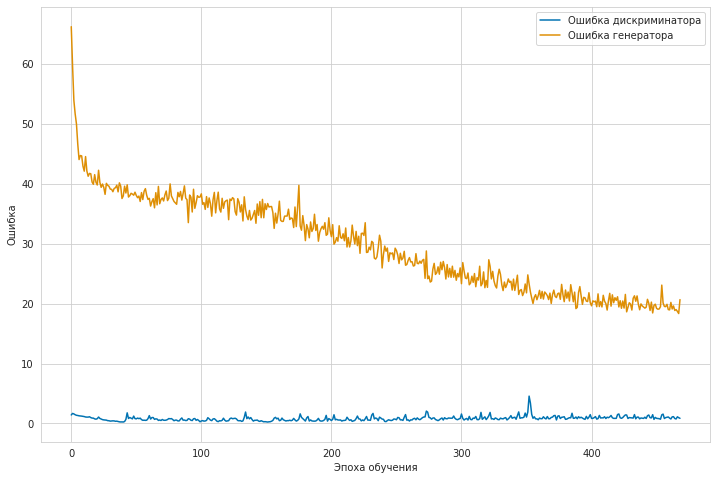

	...epoch 67/100	batch 0/7	D loss: 1.024744	G loss: 20.507298
	...epoch 67/100	batch 1/7	D loss: 0.945648	G loss: 18.421015
	...epoch 67/100	batch 2/7	D loss: 0.953633	G loss: 19.717533
	...epoch 67/100	batch 3/7	D loss: 1.022726	G loss: 19.133474
	...epoch 67/100	batch 4/7	D loss: 1.036471	G loss: 20.196680
	...epoch 67/100	batch 5/7	D loss: 0.875746	G loss: 18.472057
	...epoch 67/100	batch 6/7	D loss: 1.600346	G loss: 22.201954


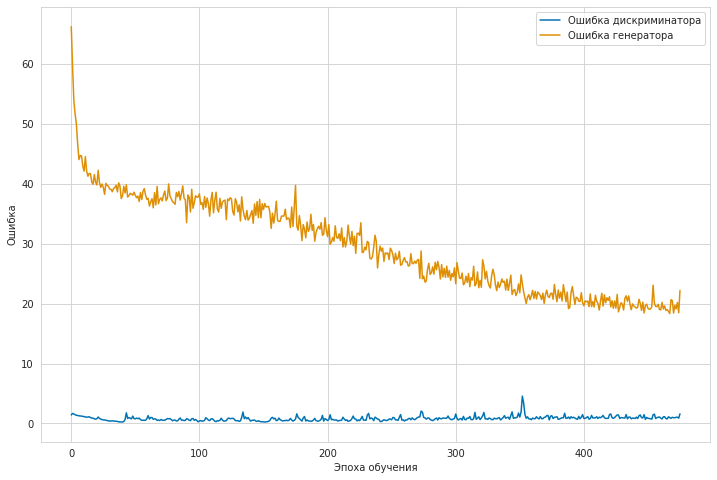

	...epoch 68/100	batch 0/7	D loss: 1.425917	G loss: 20.345926
	...epoch 68/100	batch 1/7	D loss: 0.864803	G loss: 18.375866
	...epoch 68/100	batch 2/7	D loss: 1.112064	G loss: 20.224682
	...epoch 68/100	batch 3/7	D loss: 1.503587	G loss: 18.121063
	...epoch 68/100	batch 4/7	D loss: 0.844999	G loss: 18.951895
	...epoch 68/100	batch 5/7	D loss: 0.854338	G loss: 17.953117
	...epoch 68/100	batch 6/7	D loss: 1.135110	G loss: 19.454760


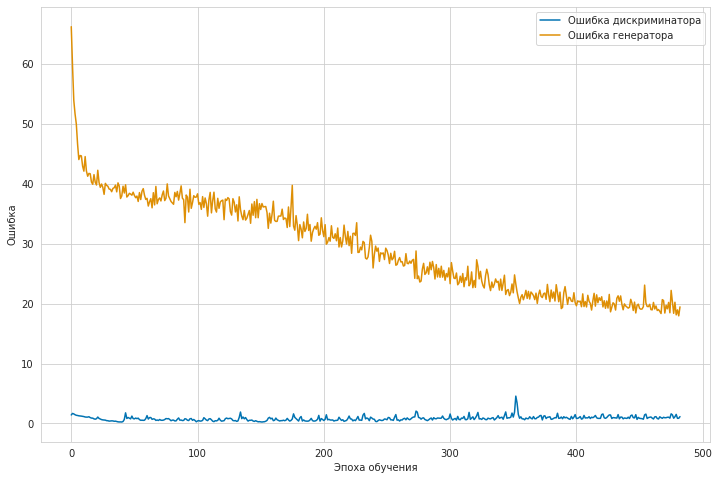

	...epoch 69/100	batch 0/7	D loss: 0.890183	G loss: 18.827208
	...epoch 69/100	batch 1/7	D loss: 0.864968	G loss: 19.066959
	...epoch 69/100	batch 2/7	D loss: 0.864191	G loss: 19.150520
	...epoch 69/100	batch 3/7	D loss: 1.162086	G loss: 19.131403
	...epoch 69/100	batch 4/7	D loss: 0.841625	G loss: 19.703777
	...epoch 69/100	batch 5/7	D loss: 0.934163	G loss: 18.249163
	...epoch 69/100	batch 6/7	D loss: 0.855630	G loss: 18.035196


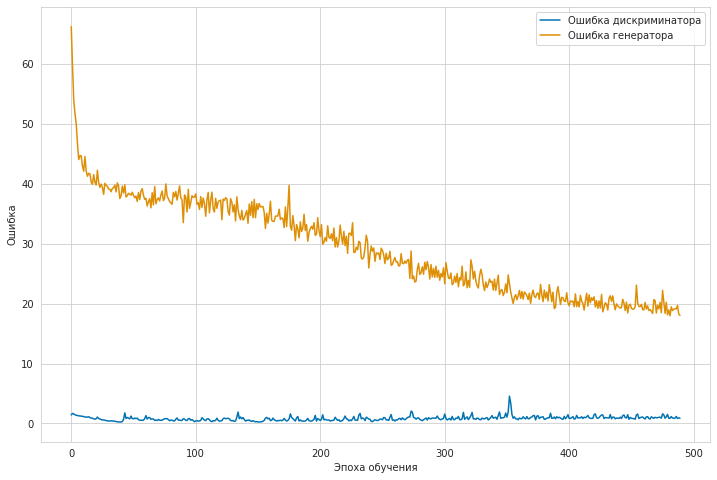

	...epoch 70/100	batch 0/7	D loss: 0.847261	G loss: 20.214544
	...epoch 70/100	batch 1/7	D loss: 1.279106	G loss: 17.502932
	...epoch 70/100	batch 2/7	D loss: 0.957313	G loss: 19.241652
	...epoch 70/100	batch 3/7	D loss: 0.886360	G loss: 17.312399
	...epoch 70/100	batch 4/7	D loss: 1.054509	G loss: 18.879555
	...epoch 70/100	batch 5/7	D loss: 0.948453	G loss: 18.598953
	...epoch 70/100	batch 6/7	D loss: 1.034805	G loss: 17.949678


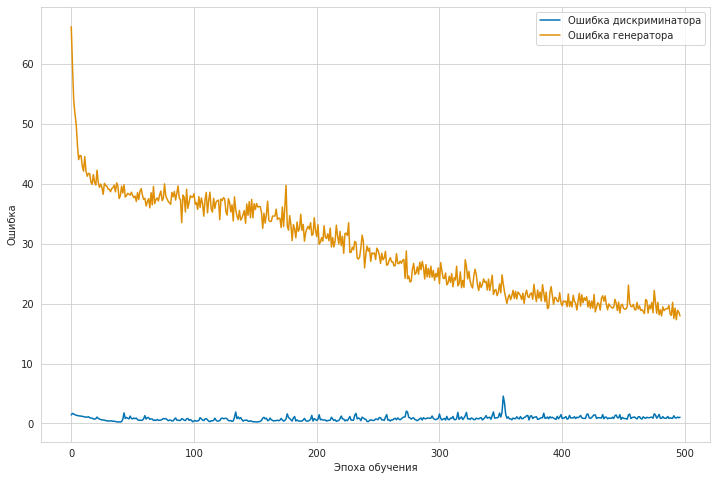

	...epoch 71/100	batch 0/7	D loss: 1.101493	G loss: 19.935108
	...epoch 71/100	batch 1/7	D loss: 1.165308	G loss: 17.824343
	...epoch 71/100	batch 2/7	D loss: 0.777878	G loss: 18.155769
	...epoch 71/100	batch 3/7	D loss: 1.010772	G loss: 18.274202
	...epoch 71/100	batch 4/7	D loss: 0.854350	G loss: 18.376360
	...epoch 71/100	batch 5/7	D loss: 0.974755	G loss: 18.391863
	...epoch 71/100	batch 6/7	D loss: 0.811558	G loss: 19.082870


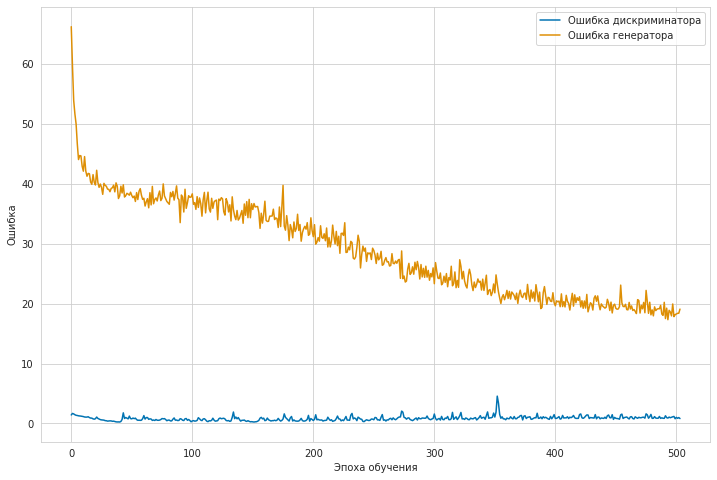

	...epoch 72/100	batch 0/7	D loss: 1.006015	G loss: 18.867188
	...epoch 72/100	batch 1/7	D loss: 1.323595	G loss: 19.247944
	...epoch 72/100	batch 2/7	D loss: 1.085142	G loss: 19.391073
	...epoch 72/100	batch 3/7	D loss: 1.321171	G loss: 17.759874
	...epoch 72/100	batch 4/7	D loss: 1.462533	G loss: 20.083971
	...epoch 72/100	batch 5/7	D loss: 1.614351	G loss: 17.469090
	...epoch 72/100	batch 6/7	D loss: 1.071003	G loss: 17.350391


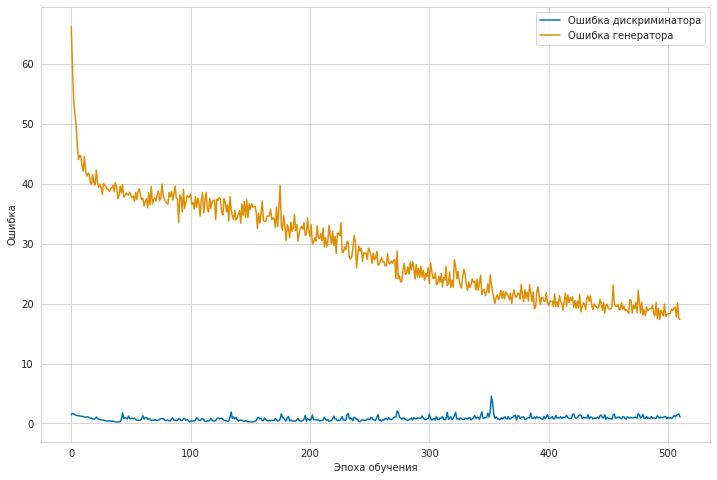

	...epoch 73/100	batch 0/7	D loss: 1.099330	G loss: 18.078495
	...epoch 73/100	batch 1/7	D loss: 1.161201	G loss: 17.689903
	...epoch 73/100	batch 2/7	D loss: 0.785479	G loss: 17.640617
	...epoch 73/100	batch 3/7	D loss: 1.022641	G loss: 17.782295
	...epoch 73/100	batch 4/7	D loss: 1.028825	G loss: 19.116482
	...epoch 73/100	batch 5/7	D loss: 1.084929	G loss: 18.117861
	...epoch 73/100	batch 6/7	D loss: 0.714572	G loss: 18.461102


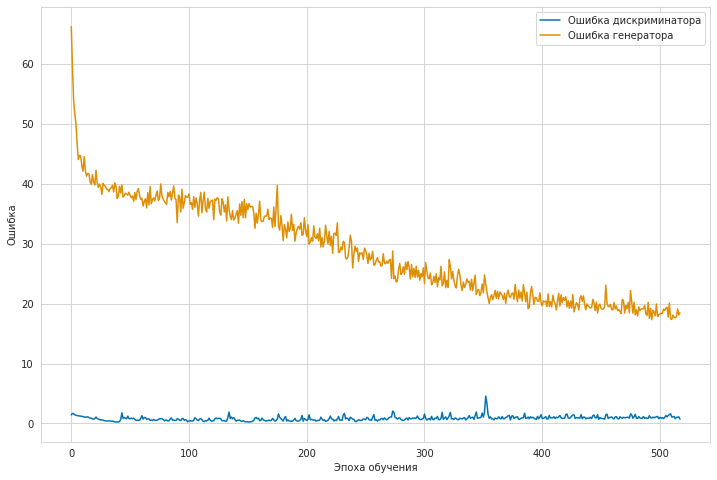

	...epoch 74/100	batch 0/7	D loss: 0.911471	G loss: 18.018557
	...epoch 74/100	batch 1/7	D loss: 1.162510	G loss: 17.142258
	...epoch 74/100	batch 2/7	D loss: 1.166046	G loss: 19.604425
	...epoch 74/100	batch 3/7	D loss: 1.356624	G loss: 18.558117
	...epoch 74/100	batch 4/7	D loss: 0.895914	G loss: 17.515795
	...epoch 74/100	batch 5/7	D loss: 0.970054	G loss: 18.342018
	...epoch 74/100	batch 6/7	D loss: 0.876709	G loss: 17.953421


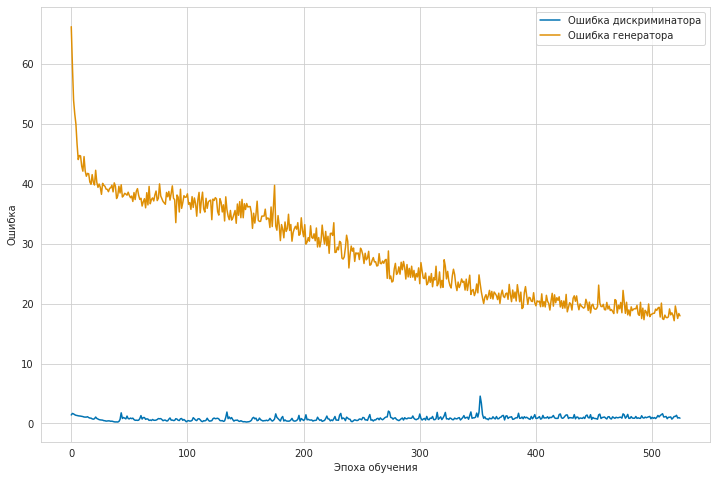

	...epoch 75/100	batch 0/7	D loss: 0.858396	G loss: 18.051155
	...epoch 75/100	batch 1/7	D loss: 0.885869	G loss: 19.615427
	...epoch 75/100	batch 2/7	D loss: 1.266524	G loss: 17.372849
	...epoch 75/100	batch 3/7	D loss: 0.849330	G loss: 17.897856
	...epoch 75/100	batch 4/7	D loss: 1.024818	G loss: 18.332607
	...epoch 75/100	batch 5/7	D loss: 1.220401	G loss: 17.275702
	...epoch 75/100	batch 6/7	D loss: 0.836764	G loss: 17.950710


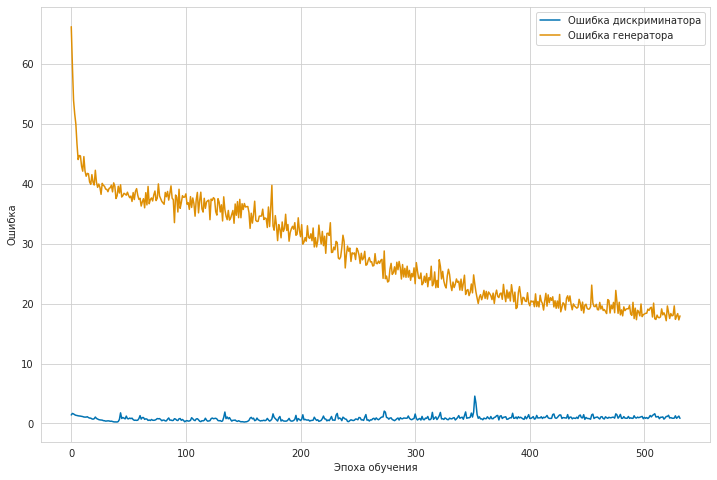

	...epoch 76/100	batch 0/7	D loss: 0.906269	G loss: 17.814198
	...epoch 76/100	batch 1/7	D loss: 0.751876	G loss: 17.954803
	...epoch 76/100	batch 2/7	D loss: 0.935142	G loss: 18.291494
	...epoch 76/100	batch 3/7	D loss: 1.424946	G loss: 17.959312
	...epoch 76/100	batch 4/7	D loss: 0.752386	G loss: 17.329626
	...epoch 76/100	batch 5/7	D loss: 0.973891	G loss: 18.115221
	...epoch 76/100	batch 6/7	D loss: 0.992797	G loss: 20.474350


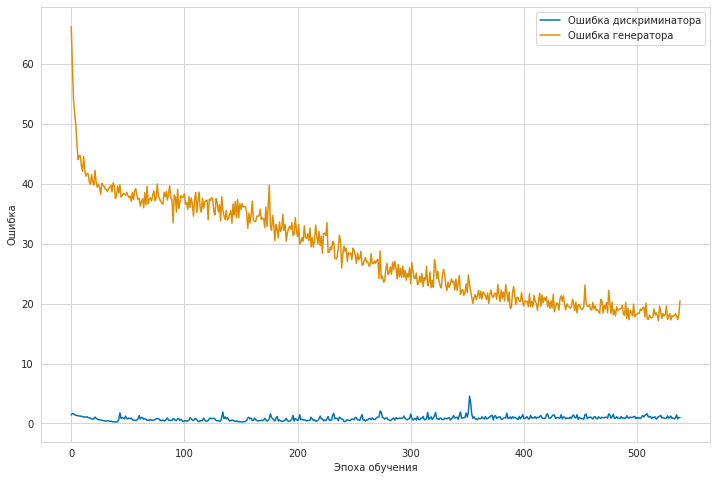

	...epoch 77/100	batch 0/7	D loss: 1.102663	G loss: 17.164690
	...epoch 77/100	batch 1/7	D loss: 1.185936	G loss: 18.553120
	...epoch 77/100	batch 2/7	D loss: 1.116413	G loss: 17.292112
	...epoch 77/100	batch 3/7	D loss: 0.744120	G loss: 17.603968
	...epoch 77/100	batch 4/7	D loss: 0.890099	G loss: 17.306301
	...epoch 77/100	batch 5/7	D loss: 0.940168	G loss: 17.721645
	...epoch 77/100	batch 6/7	D loss: 0.987156	G loss: 17.375467


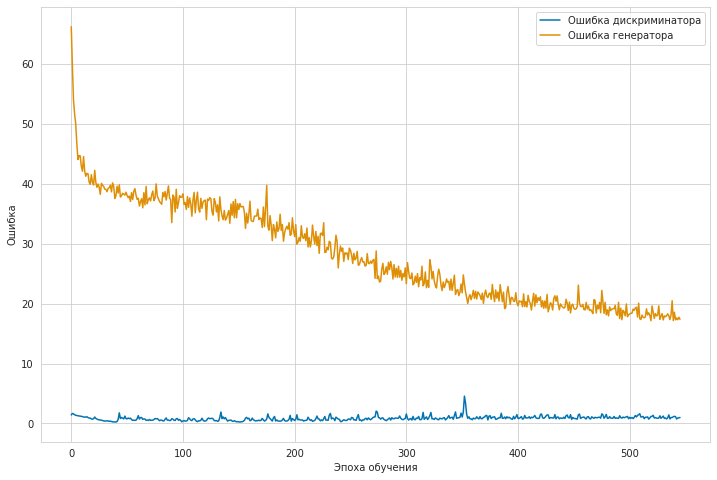

	...epoch 78/100	batch 0/7	D loss: 1.023787	G loss: 17.990009
	...epoch 78/100	batch 1/7	D loss: 0.970218	G loss: 19.177860
	...epoch 78/100	batch 2/7	D loss: 1.032084	G loss: 18.029911
	...epoch 78/100	batch 3/7	D loss: 1.039219	G loss: 17.196163
	...epoch 78/100	batch 4/7	D loss: 0.926197	G loss: 18.263117
	...epoch 78/100	batch 5/7	D loss: 0.850251	G loss: 18.339540
	...epoch 78/100	batch 6/7	D loss: 0.802008	G loss: 16.771894


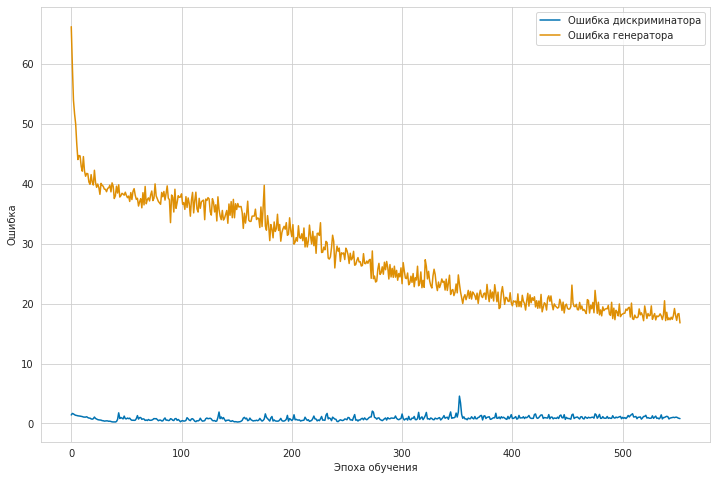

	...epoch 79/100	batch 0/7	D loss: 1.025270	G loss: 17.501274
	...epoch 79/100	batch 1/7	D loss: 1.004920	G loss: 17.916061
	...epoch 79/100	batch 2/7	D loss: 1.266905	G loss: 17.260754
	...epoch 79/100	batch 3/7	D loss: 1.181285	G loss: 17.290842
	...epoch 79/100	batch 4/7	D loss: 1.057132	G loss: 17.339903
	...epoch 79/100	batch 5/7	D loss: 0.930579	G loss: 19.457760
	...epoch 79/100	batch 6/7	D loss: 1.587081	G loss: 17.736622


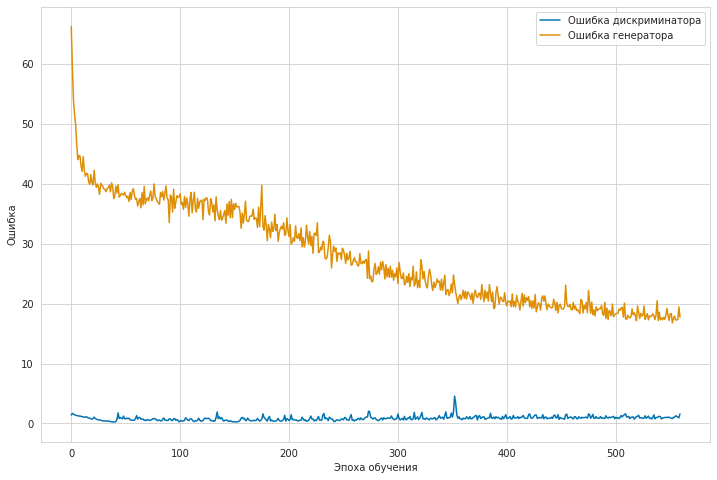

	...epoch 80/100	batch 0/7	D loss: 0.822077	G loss: 17.180660
	...epoch 80/100	batch 1/7	D loss: 0.854414	G loss: 18.962458
	...epoch 80/100	batch 2/7	D loss: 1.078339	G loss: 16.813181
	...epoch 80/100	batch 3/7	D loss: 0.829823	G loss: 17.643623
	...epoch 80/100	batch 4/7	D loss: 1.176654	G loss: 17.392918
	...epoch 80/100	batch 5/7	D loss: 0.854906	G loss: 16.904840
	...epoch 80/100	batch 6/7	D loss: 0.777807	G loss: 17.445969


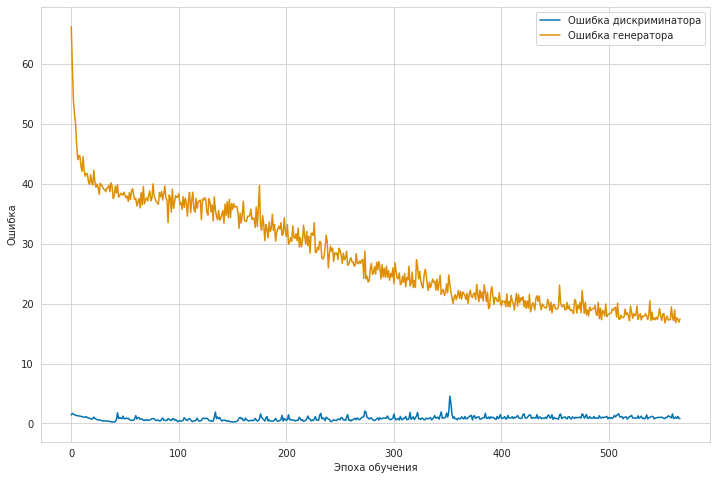

	...epoch 81/100	batch 0/7	D loss: 0.844604	G loss: 17.255573
	...epoch 81/100	batch 1/7	D loss: 0.959631	G loss: 19.168901
	...epoch 81/100	batch 2/7	D loss: 1.074141	G loss: 17.633776
	...epoch 81/100	batch 3/7	D loss: 0.956586	G loss: 16.661730
	...epoch 81/100	batch 4/7	D loss: 0.986483	G loss: 18.518826
	...epoch 81/100	batch 5/7	D loss: 1.150923	G loss: 17.171032
	...epoch 81/100	batch 6/7	D loss: 1.102618	G loss: 18.791874


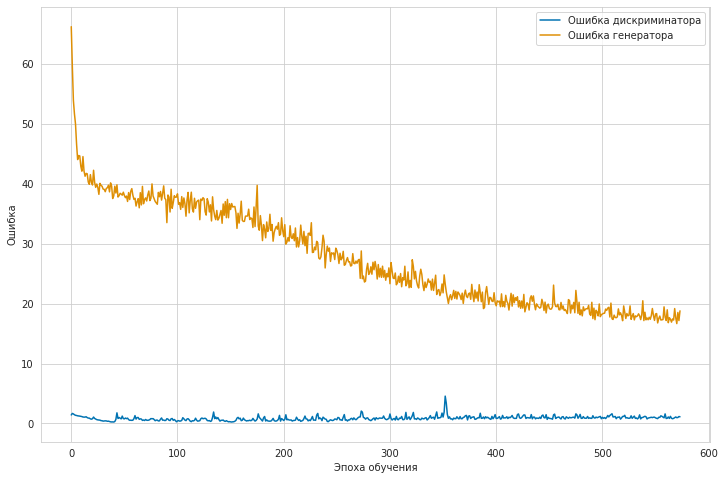

	...epoch 82/100	batch 0/7	D loss: 0.997782	G loss: 17.480381
	...epoch 82/100	batch 1/7	D loss: 0.795731	G loss: 16.993511
	...epoch 82/100	batch 2/7	D loss: 1.061711	G loss: 17.896904
	...epoch 82/100	batch 3/7	D loss: 0.979532	G loss: 18.060442
	...epoch 82/100	batch 4/7	D loss: 1.023314	G loss: 16.856968
	...epoch 82/100	batch 5/7	D loss: 1.054566	G loss: 18.073624
	...epoch 82/100	batch 6/7	D loss: 1.120740	G loss: 16.055017


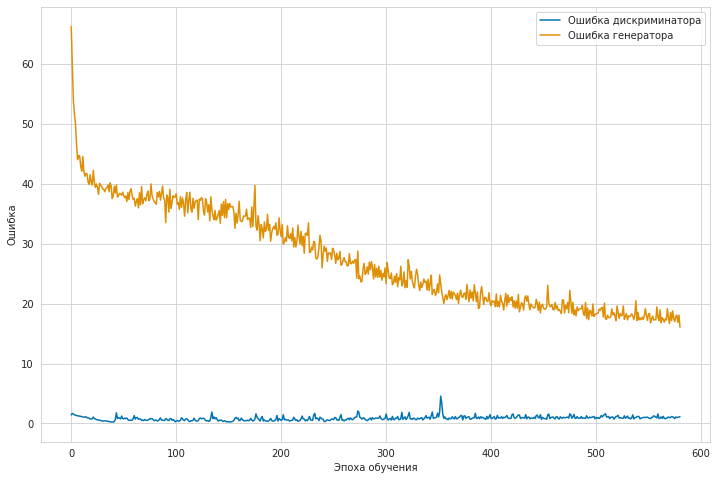

	...epoch 83/100	batch 0/7	D loss: 0.955929	G loss: 18.501989
	...epoch 83/100	batch 1/7	D loss: 0.848291	G loss: 17.233395
	...epoch 83/100	batch 2/7	D loss: 0.794978	G loss: 17.180531
	...epoch 83/100	batch 3/7	D loss: 1.017650	G loss: 17.897440
	...epoch 83/100	batch 4/7	D loss: 1.129628	G loss: 16.615761
	...epoch 83/100	batch 5/7	D loss: 1.076530	G loss: 18.006445
	...epoch 83/100	batch 6/7	D loss: 1.684367	G loss: 18.716558


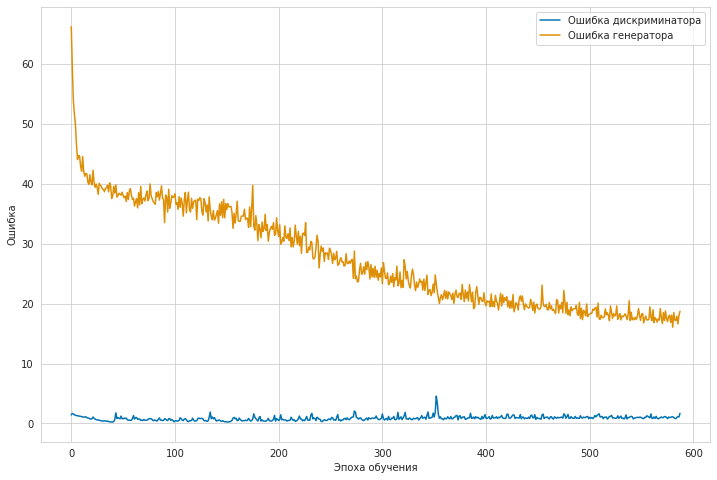

	...epoch 84/100	batch 0/7	D loss: 1.124718	G loss: 17.182564
	...epoch 84/100	batch 1/7	D loss: 1.236879	G loss: 18.764103
	...epoch 84/100	batch 2/7	D loss: 0.938306	G loss: 17.401472
	...epoch 84/100	batch 3/7	D loss: 0.966015	G loss: 17.154192
	...epoch 84/100	batch 4/7	D loss: 0.961484	G loss: 16.738945
	...epoch 84/100	batch 5/7	D loss: 0.902439	G loss: 16.444048
	...epoch 84/100	batch 6/7	D loss: 0.728318	G loss: 17.126877


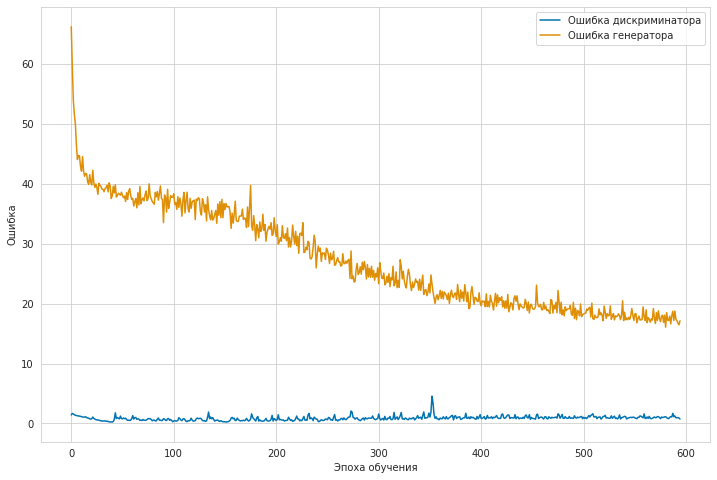

	...epoch 85/100	batch 0/7	D loss: 1.255554	G loss: 19.672607
	...epoch 85/100	batch 1/7	D loss: 1.498670	G loss: 17.566189
	...epoch 85/100	batch 2/7	D loss: 0.956475	G loss: 17.128155
	...epoch 85/100	batch 3/7	D loss: 0.960310	G loss: 17.703127
	...epoch 85/100	batch 4/7	D loss: 1.159802	G loss: 17.178183
	...epoch 85/100	batch 5/7	D loss: 0.892111	G loss: 16.513048
	...epoch 85/100	batch 6/7	D loss: 1.250716	G loss: 19.103191


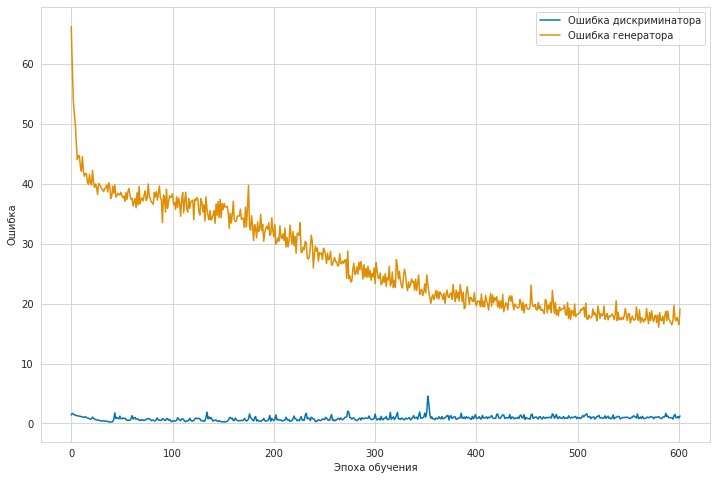

	...epoch 86/100	batch 0/7	D loss: 1.856402	G loss: 17.827049
	...epoch 86/100	batch 1/7	D loss: 1.095792	G loss: 15.837452
	...epoch 86/100	batch 2/7	D loss: 1.697120	G loss: 18.087238
	...epoch 86/100	batch 3/7	D loss: 0.949465	G loss: 17.296761
	...epoch 86/100	batch 4/7	D loss: 0.947604	G loss: 15.869860
	...epoch 86/100	batch 5/7	D loss: 0.895174	G loss: 17.418299
	...epoch 86/100	batch 6/7	D loss: 0.917434	G loss: 17.175133


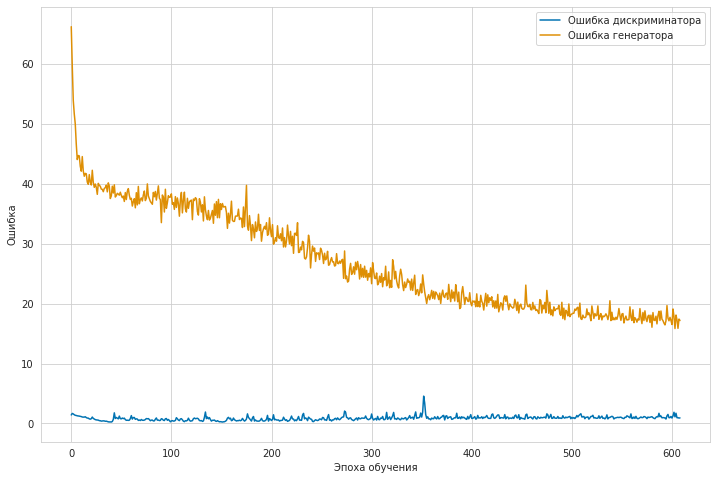

	...epoch 87/100	batch 0/7	D loss: 1.063813	G loss: 17.336908
	...epoch 87/100	batch 1/7	D loss: 0.767717	G loss: 16.792732
	...epoch 87/100	batch 2/7	D loss: 0.729529	G loss: 16.423706
	...epoch 87/100	batch 3/7	D loss: 0.838322	G loss: 16.510298
	...epoch 87/100	batch 4/7	D loss: 0.847978	G loss: 16.311676
	...epoch 87/100	batch 5/7	D loss: 1.114401	G loss: 17.781050
	...epoch 87/100	batch 6/7	D loss: 1.111105	G loss: 16.776842


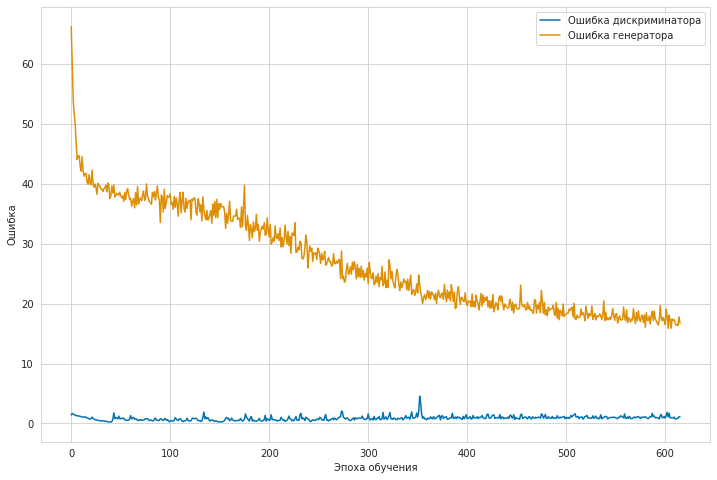

	...epoch 88/100	batch 0/7	D loss: 0.742758	G loss: 17.451717
	...epoch 88/100	batch 1/7	D loss: 0.950836	G loss: 18.751308
	...epoch 88/100	batch 2/7	D loss: 1.738077	G loss: 16.427839
	...epoch 88/100	batch 3/7	D loss: 0.870995	G loss: 16.020678
	...epoch 88/100	batch 4/7	D loss: 1.047808	G loss: 16.466145
	...epoch 88/100	batch 5/7	D loss: 1.040959	G loss: 16.073565
	...epoch 88/100	batch 6/7	D loss: 0.955601	G loss: 15.171926


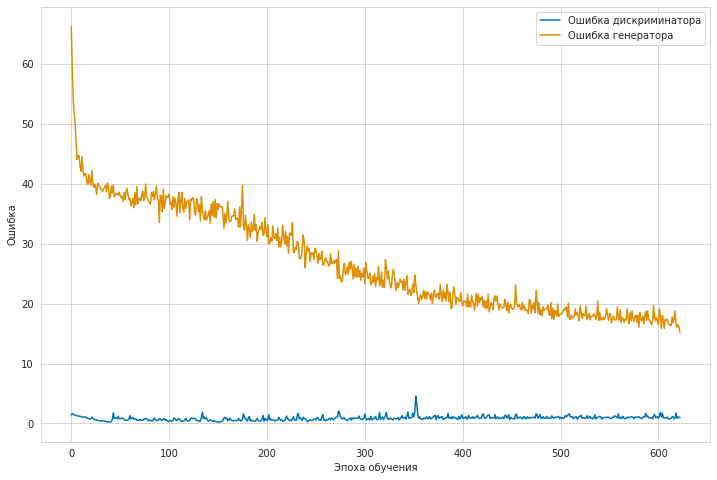

	...epoch 89/100	batch 0/7	D loss: 0.909769	G loss: 17.149130
	...epoch 89/100	batch 1/7	D loss: 1.044902	G loss: 16.110561
	...epoch 89/100	batch 2/7	D loss: 0.882310	G loss: 15.540108
	...epoch 89/100	batch 3/7	D loss: 0.941885	G loss: 16.782751
	...epoch 89/100	batch 4/7	D loss: 0.782709	G loss: 17.245674
	...epoch 89/100	batch 5/7	D loss: 1.305090	G loss: 16.334131
	...epoch 89/100	batch 6/7	D loss: 1.015076	G loss: 17.226843


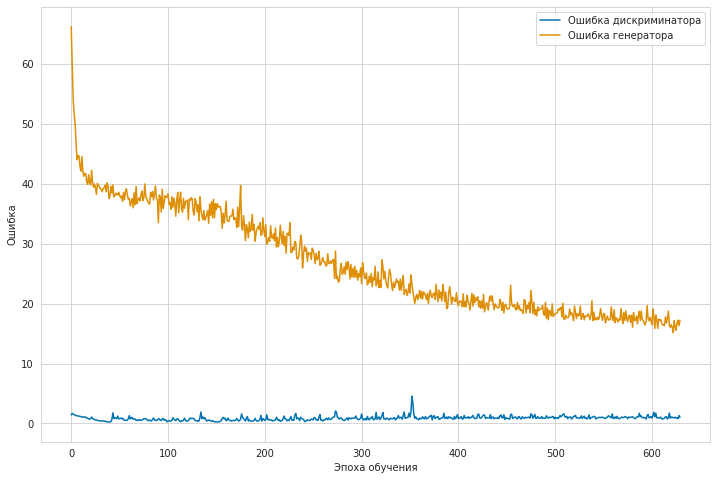

	...epoch 90/100	batch 0/7	D loss: 0.610568	G loss: 17.890749
	...epoch 90/100	batch 1/7	D loss: 0.884384	G loss: 16.420197
	...epoch 90/100	batch 2/7	D loss: 1.045403	G loss: 16.356550
	...epoch 90/100	batch 3/7	D loss: 0.862833	G loss: 15.734278
	...epoch 90/100	batch 4/7	D loss: 0.987450	G loss: 17.103415
	...epoch 90/100	batch 5/7	D loss: 1.080669	G loss: 16.729357
	...epoch 90/100	batch 6/7	D loss: 1.278666	G loss: 15.976233


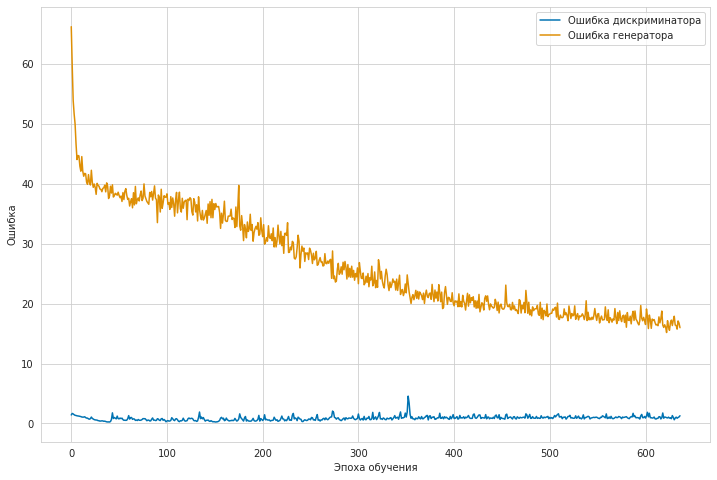

	...epoch 91/100	batch 0/7	D loss: 0.750451	G loss: 17.071424
	...epoch 91/100	batch 1/7	D loss: 0.955266	G loss: 15.880862
	...epoch 91/100	batch 2/7	D loss: 0.889483	G loss: 16.882162
	...epoch 91/100	batch 3/7	D loss: 0.963117	G loss: 15.885971
	...epoch 91/100	batch 4/7	D loss: 0.974463	G loss: 16.580084
	...epoch 91/100	batch 5/7	D loss: 1.105414	G loss: 16.130108
	...epoch 91/100	batch 6/7	D loss: 1.129044	G loss: 17.885950


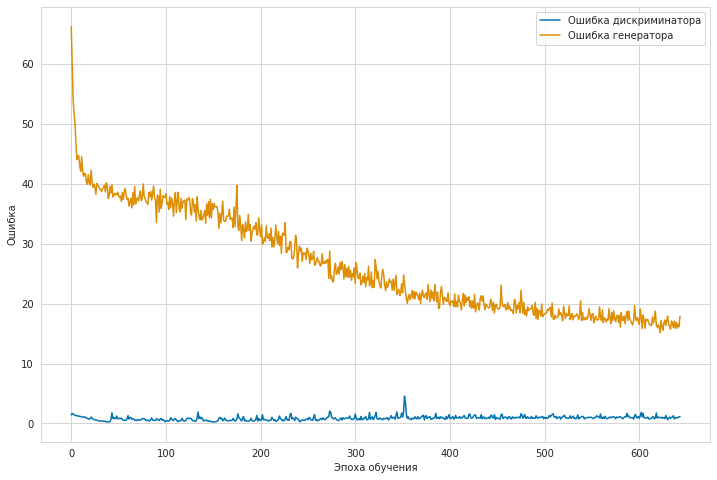

	...epoch 92/100	batch 0/7	D loss: 1.528364	G loss: 15.519213
	...epoch 92/100	batch 1/7	D loss: 0.925133	G loss: 16.724258
	...epoch 92/100	batch 2/7	D loss: 0.864632	G loss: 16.510422
	...epoch 92/100	batch 3/7	D loss: 1.018294	G loss: 16.188276
	...epoch 92/100	batch 4/7	D loss: 0.930022	G loss: 15.842211
	...epoch 92/100	batch 5/7	D loss: 0.869031	G loss: 17.887182
	...epoch 92/100	batch 6/7	D loss: 0.881334	G loss: 16.775602


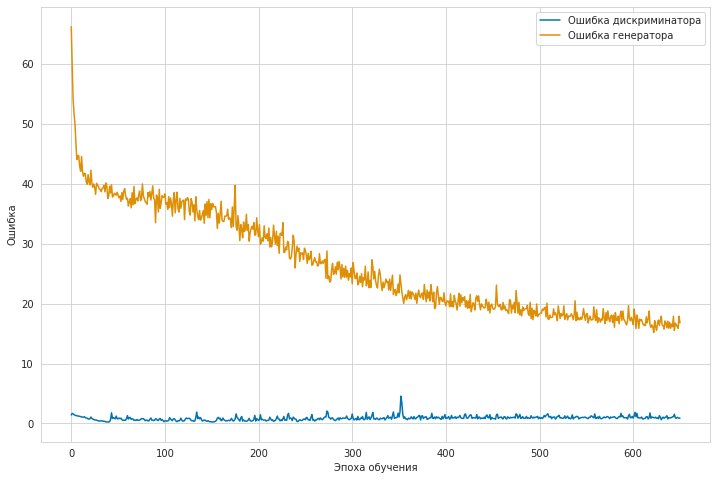

	...epoch 93/100	batch 0/7	D loss: 1.078762	G loss: 15.889717
	...epoch 93/100	batch 1/7	D loss: 1.008391	G loss: 17.099785
	...epoch 93/100	batch 2/7	D loss: 1.339761	G loss: 15.203522
	...epoch 93/100	batch 3/7	D loss: 0.905963	G loss: 16.625425
	...epoch 93/100	batch 4/7	D loss: 0.922111	G loss: 16.204573
	...epoch 93/100	batch 5/7	D loss: 0.951365	G loss: 16.282894
	...epoch 93/100	batch 6/7	D loss: 0.826791	G loss: 17.872231


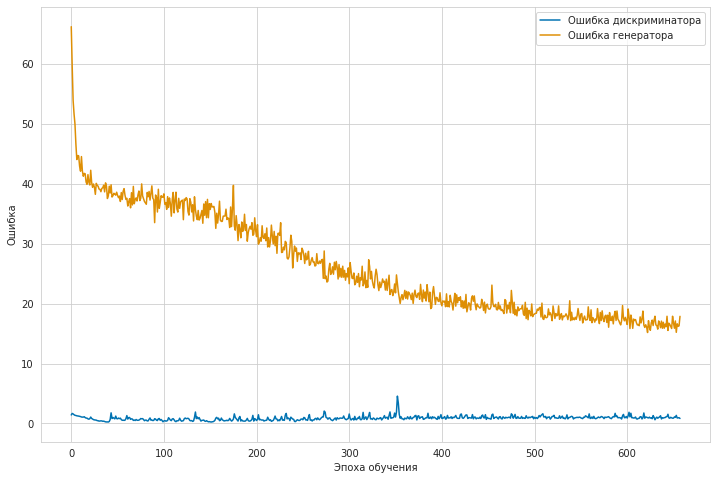

	...epoch 94/100	batch 0/7	D loss: 1.214235	G loss: 16.461199
	...epoch 94/100	batch 1/7	D loss: 0.867092	G loss: 15.366770
	...epoch 94/100	batch 2/7	D loss: 0.879409	G loss: 16.326044
	...epoch 94/100	batch 3/7	D loss: 0.888448	G loss: 15.742128
	...epoch 94/100	batch 4/7	D loss: 0.845450	G loss: 15.566548
	...epoch 94/100	batch 5/7	D loss: 1.075118	G loss: 16.356138
	...epoch 94/100	batch 6/7	D loss: 0.821897	G loss: 15.466869


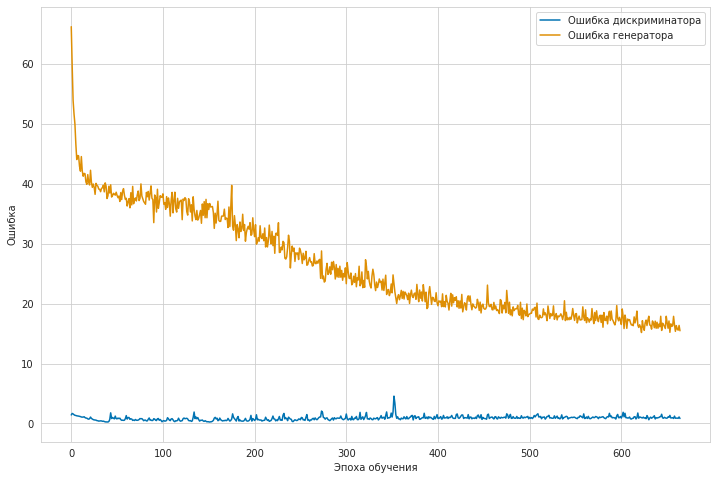

	...epoch 95/100	batch 0/7	D loss: 1.231178	G loss: 16.787447
	...epoch 95/100	batch 1/7	D loss: 1.061187	G loss: 16.377520
	...epoch 95/100	batch 2/7	D loss: 1.189952	G loss: 17.113194
	...epoch 95/100	batch 3/7	D loss: 1.021606	G loss: 16.337442
	...epoch 95/100	batch 4/7	D loss: 1.050681	G loss: 15.584070
	...epoch 95/100	batch 5/7	D loss: 1.107549	G loss: 16.567144
	...epoch 95/100	batch 6/7	D loss: 0.994668	G loss: 15.982113


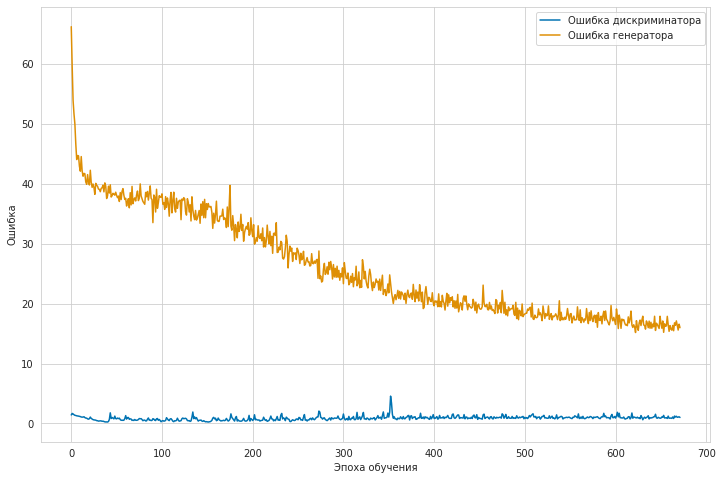

	...epoch 96/100	batch 0/7	D loss: 1.065674	G loss: 16.234251
	...epoch 96/100	batch 1/7	D loss: 1.068328	G loss: 17.209244
	...epoch 96/100	batch 2/7	D loss: 1.512967	G loss: 15.232154
	...epoch 96/100	batch 3/7	D loss: 1.006689	G loss: 16.617203
	...epoch 96/100	batch 4/7	D loss: 1.028660	G loss: 16.033428
	...epoch 96/100	batch 5/7	D loss: 1.043240	G loss: 16.292824
	...epoch 96/100	batch 6/7	D loss: 1.213401	G loss: 14.484960


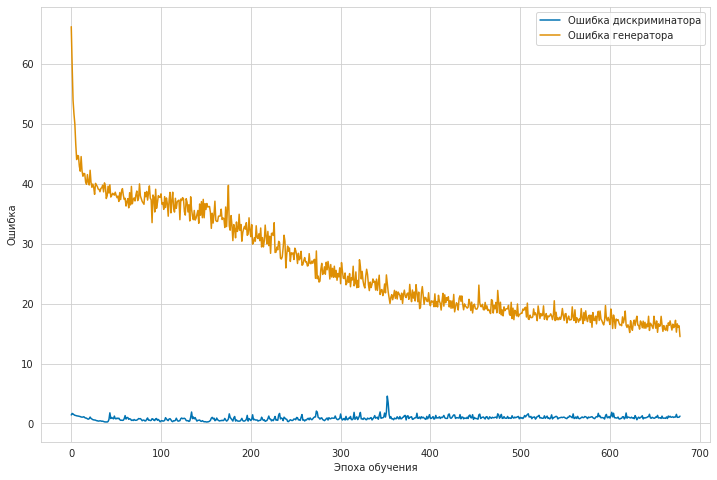

	...epoch 97/100	batch 0/7	D loss: 1.106073	G loss: 16.762909
	...epoch 97/100	batch 1/7	D loss: 0.774205	G loss: 16.618839
	...epoch 97/100	batch 2/7	D loss: 1.003125	G loss: 15.147404
	...epoch 97/100	batch 3/7	D loss: 1.050281	G loss: 16.060871
	...epoch 97/100	batch 4/7	D loss: 0.828380	G loss: 15.549755
	...epoch 97/100	batch 5/7	D loss: 0.981207	G loss: 15.597945
	...epoch 97/100	batch 6/7	D loss: 1.029823	G loss: 17.922585


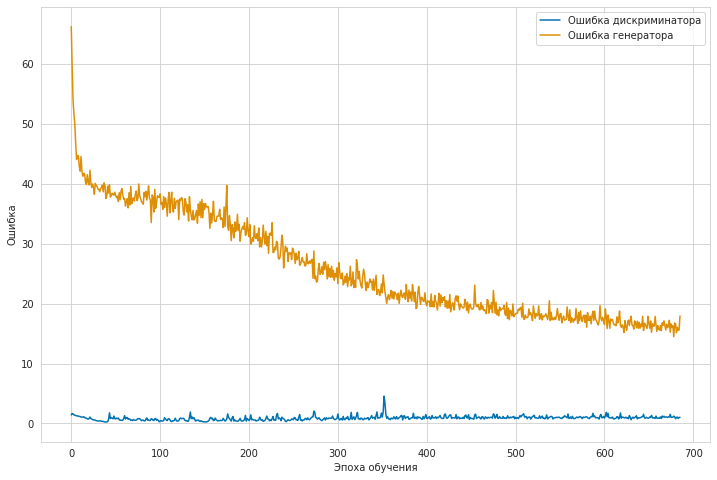

	...epoch 98/100	batch 0/7	D loss: 1.350212	G loss: 17.044558
	...epoch 98/100	batch 1/7	D loss: 0.830461	G loss: 15.884724
	...epoch 98/100	batch 2/7	D loss: 0.971802	G loss: 15.961872
	...epoch 98/100	batch 3/7	D loss: 1.086251	G loss: 16.068333
	...epoch 98/100	batch 4/7	D loss: 0.771976	G loss: 15.627179
	...epoch 98/100	batch 5/7	D loss: 1.088877	G loss: 15.943207
	...epoch 98/100	batch 6/7	D loss: 0.696590	G loss: 16.190277


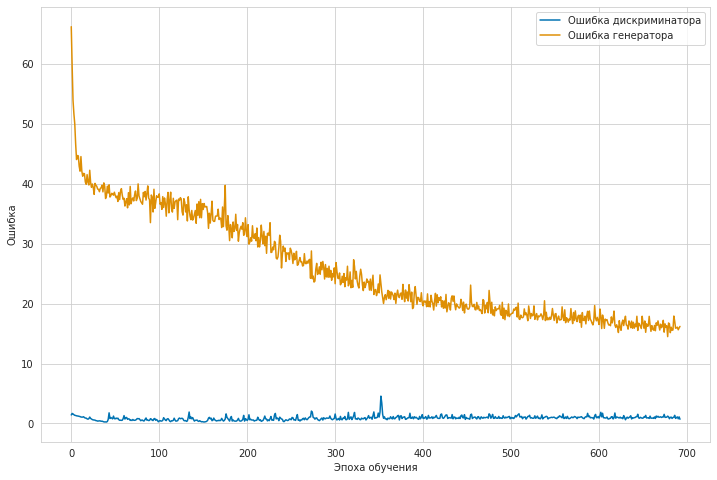

	...epoch 99/100	batch 0/7	D loss: 1.271434	G loss: 15.474136
	...epoch 99/100	batch 1/7	D loss: 1.026333	G loss: 16.624609
	...epoch 99/100	batch 2/7	D loss: 1.232851	G loss: 15.078913
	...epoch 99/100	batch 3/7	D loss: 0.833262	G loss: 15.659742
	...epoch 99/100	batch 4/7	D loss: 0.899919	G loss: 15.916793
	...epoch 99/100	batch 5/7	D loss: 1.037087	G loss: 15.631557
	...epoch 99/100	batch 6/7	D loss: 1.346669	G loss: 17.773870


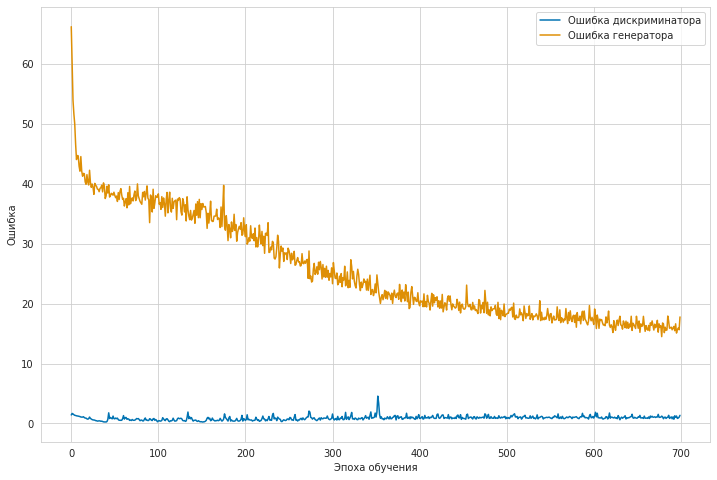

In [10]:
from torchvision.utils import save_image


batch_size = 64

transform = transforms.Compose([
                  transforms.ToTensor(),
                 transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

path_to_data = '/content/drive/MyDrive/datasets/facades/'

train_data = loadData(path_to_data, 'train', transform)

train_data_loader = torch.utils.data.DataLoader(dataset=train_data,
                                                batch_size=batch_size,
                                                shuffle=True)

test_data = loadData(path_to_data, 'test', transform)
test_data_loader = torch.utils.data.DataLoader(dataset=test_data,
                                               batch_size=batch_size,
                                               shuffle=False)


G = Generator(3, 3)
D = Discriminator(6)
G.cuda()
D.cuda()

BCE_loss = torch.nn.BCELoss().cuda()
L1_loss = torch.nn.L1Loss().cuda()

lr, beta1, beta2 = 0.0002, 0.5, 0.999
G_optimizer = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta1, beta2))
D_optimizer = torch.optim.Adam(D.parameters(), lr=lr, betas=(beta1, beta2))

batches_done = 0

num_epochs = 100

D_losses = []
G_losses = []

for epoch in range(num_epochs):


    for i, (input, target) in enumerate(train_data_loader):

        x_ = Variable(input.cuda())
        y_ = Variable(target.cuda())

        # подаем реальные данные
        D_real = D(x_, y_).squeeze()
        real_ = Variable(torch.ones(D_real.size()).cuda())
        D_real_loss = BCE_loss(D_real, real_)

        # подаем сгенерированные данные
        gen_image = G(x_)
        D_fake = D(x_, gen_image).squeeze()
        fake_ = Variable(torch.zeros(D_fake.size()).cuda())
        D_fake_loss = BCE_loss(D_fake, fake_)

        # пропагиируем дискриминатор
        D_loss = D_real_loss + D_fake_loss
        D.zero_grad()
        D_loss.backward()
        D_optimizer.step()

        # тренеруем генератор
        gen_image = G(x_)
        D_fake_decision = D(x_, gen_image).squeeze()
        G_fake_loss = BCE_loss(D_fake_decision, real_)

        l1_loss = 100 * L1_loss(gen_image, y_)

        # пропагиируем генератор
        G_loss = G_fake_loss + l1_loss
        G.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        D_losses.append(D_loss.data.item())
        G_losses.append(G_loss.data.item())
        print("\t...epoch %d/%d\tbatch %d/%d\tD loss: %.6f\tG loss: %.6f" % \
                      (epoch, num_epochs, i, len(train_data_loader),  D_loss.data.item(), G_loss.data.item()))

        batches_done += 1

        if batches_done % 100 == 0:
                gen_imgs = G(x_)
                gen_imgs = gen_image.cpu().data
                save_image(gen_imgs.data[:5], "%s/%05d.png" % (path_to_data + "/out/", batches_done), nrow=5, normalize=True)

    plot_losses(D_losses,G_losses )

for i, (input, target) in enumerate(test_data_loader):
          x_ = Variable(input.cuda())
          y_ = Variable(target.cuda())
          gen_imgs = G(x_)
          gen_imgs = gen_imgs.cpu().data
          save_image(gen_imgs.data, "%s/%05d.png" % (path_to_data + "/result/", batches_done), nrow=5, normalize=True)



In [11]:
torch.cuda.empty_cache()

## CycleGAN

In [12]:
class Discriminator(torch.nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()

        self.conv1 = ConvBlock(input_dim, 64, activation=False, batch_norm=False)
        self.conv2 = ConvBlock(64, 128)
        self.conv3 = ConvBlock(128, 256)
        self.conv4 = ConvBlock(256, 512, stride=1)
        self.conv5 = ConvBlock(512, 1, stride=1, batch_norm=False)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        out = torch.nn.Sigmoid()(x)
        return out

    def normal_weight_init(self, mean=0.0, std=0.02):
        for m in self.children():
            if isinstance(m, ConvBlock):
                torch.nn.init.normal(m.conv.weight, mean, std)


In [13]:
from torchsummary import summary

In [14]:
summary(Discriminator(3).cuda(),(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
         ConvBlock-2         [-1, 64, 128, 128]               0
         LeakyReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4          [-1, 128, 64, 64]         131,200
       BatchNorm2d-5          [-1, 128, 64, 64]             256
         ConvBlock-6          [-1, 128, 64, 64]               0
         LeakyReLU-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 256, 32, 32]         524,544
       BatchNorm2d-9          [-1, 256, 32, 32]             512
        ConvBlock-10          [-1, 256, 32, 32]               0
        LeakyReLU-11          [-1, 256, 32, 32]               0
           Conv2d-12          [-1, 512, 31, 31]       2,097,664
      BatchNorm2d-13          [-1, 512, 31, 31]           1,024
        ConvBlock-14          [-1, 512,

In [15]:

from torchvision.utils import save_image
import itertools

batch_size = 32

transform = transforms.Compose([
                  transforms.ToTensor(),
                 transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

path_to_data = '/content/drive/MyDrive/datasets/facades/'

train_data = loadData(path_to_data, 'train', transform)

train_data_loader = torch.utils.data.DataLoader(dataset=train_data,
                                                batch_size=batch_size,
                                                shuffle=True)

test_data = loadData(path_to_data, 'test', transform)
test_data_loader = torch.utils.data.DataLoader(dataset=test_data,
                                               batch_size=batch_size,
                                               shuffle=False)


GA2B = Generator(3, 3)
DA = Discriminator(3)
GB2A = Generator(3, 3)
DB = Discriminator(3)

GA2B.cuda()
DA.cuda()
GB2A.cuda()
DB.cuda()

cycle_loss = torch.nn.L1Loss().cuda()
identity_loss = torch.nn.L1Loss().cuda()
adversarial_loss = torch.nn.MSELoss().cuda()

identity_losses = []
gan_losses = []
cycle_losses = []

lr, beta1, beta2 = 0.0002, 0.5, 0.999

G_optimizer = torch.optim.Adam(itertools.chain(GA2B.parameters(), 
                GB2A.parameters()), lr=lr, betas=(beta1, beta2))

DA_optimizer = torch.optim.Adam(DA.parameters(), lr=lr, betas=(beta1, beta2))
DB_optimizer = torch.optim.Adam(DB.parameters(), lr=lr, betas=(beta1, beta2))

batches_done = 0

num_epochs = 200
D_losses = []
G_losses = []

for epoch in range(num_epochs):
    for i, (input, target) in enumerate(train_data_loader):

        A_ = Variable(input.cuda())
        B_ = Variable(target.cuda())

        real_ = Variable(torch.ones(DA(A_).squeeze().size()).cuda())
        fake_ = Variable(torch.zeros(DA(A_).squeeze().size()).cuda())

        G_optimizer.zero_grad()
        # identity loss
        identity_image_A = GB2A(A_)
        loss_identity_A = identity_loss(identity_image_A, A_) 

        identity_image_B = GA2B(B_)
        loss_identity_B = identity_loss(identity_image_B, B_)

        # GAN loss
        fake_A = GB2A(B_)
        fake_output_A = DA(fake_A)
        loss_GAN_B2A = adversarial_loss(fake_output_A, real_) 

        fake_B = GA2B(A_)
        fake_output_B = DB(fake_B)
        loss_GAN_A2B = adversarial_loss(fake_output_B, real_) 

        # Cycle loss
        recovered_A = GB2A(fake_B)
        loss_cycle_ABA = cycle_loss(recovered_A, A_) 

        recovered_B = GA2B(fake_A)
        loss_cycle_BAB = cycle_loss(recovered_B, B_) 

        errG = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB
        
        print(loss_identity_A.item(), loss_identity_B.item(), loss_GAN_A2B.item(),loss_GAN_B2A.item(),loss_cycle_ABA.item(), loss_cycle_BAB.item() )
        errG.backward()


        G_optimizer.step()

        # DA discr
        DA_optimizer.zero_grad()

        real_output_A = DA(A_)
        errD_real_A = adversarial_loss(real_output_A, real_)

        fake_output_A = DA(fake_A.detach())
        errD_fake_A = adversarial_loss(fake_output_A, fake_)

        errD_A = errD_real_A + errD_fake_A

        errD_A.backward()
        DA_optimizer.step()

        # DB discr
        DB_optimizer.zero_grad()

        real_output_B = DB(B_)
        errD_real_B = adversarial_loss(real_output_B, real_)

        fake_output_B = DB(fake_B.detach())
        errD_fake_B = adversarial_loss(fake_output_B, fake_)

        errD_B = errD_real_B + errD_fake_B

        errD_B.backward()
        DB_optimizer.step()

        D_loss = (errD_A + errD_B).data.item()
        G_loss = errG.data.item()
        D_losses.append(D_loss)
        G_losses.append(G_loss)
        print("\t...epoch %d/%d\tbatch %d/%d\tD loss: %.6f\tG loss: %.6f" % \
                      (epoch, num_epochs, i, len(train_data_loader),  D_loss, G_loss))

        batches_done += 1

        if batches_done % 100 == 0:
                gen_imgs = GA2B(A_)
                gen_imgs = gen_imgs.cpu().data
                save_image(gen_imgs.data, "%s/%05d.png" % (path_to_data + "/resultCycle/", batches_done), nrow=5, normalize=True)

    plot_losses(D_losses,G_losses )


for i, (input, target) in enumerate(test_data_loader):
          x_ = Variable(input.cuda())
          y_ = Variable(target.cuda())
          gen_imgsB = GA2B(x_)
          gen_imgsB = gen_imgsB.cpu().data
          
          gen_imgsA = GB2A(x_)
          gen_imgsA = gen_imgsA.cpu().data

          save_image(gen_imgs.dataB, "%s/%05dB.png" % (path_to_data + "/resultCycle/", batches_done), nrow=5, normalize=True)
          save_image(gen_imgs.dataA, "%s/%05dA.png" % (path_to_data + "/resultCycle/", batches_done), nrow=5, normalize=True)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([32, 30, 30])) that is different to the input size (torch.Size([32, 1, 30, 30])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: ignored

In [ ]:
for i, (input, target) in enumerate(test_data_loader):
          x_ = Variable(input.cuda())
          y_ = Variable(target.cuda())
          gen_imgs = GA2B(x_)
          gen_imgs = gen_image.cpu().data
          save_image(gen_imgs.data[:], "Cycle%s/%05d.png" % (path_to_data + "/result/", batches_done), nrow=500, normalize=True)
